# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import itertools

import os
import pickle

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import cohen_kappa_score, accuracy_score, classification_report, confusion_matrix, make_scorer
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate

SMALL_SIZE = 8
MEDIUM_SIZE = 12
BIGGER_SIZE = 16
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Read in Cleaned Text Datasets

Datasets were pre-cleaned to remove punctuation, lemmatize and perform stopword removal. I only read in the Drugs.com training and testing sets separately because that is the source that I decided to create the models based off of. This is because the total number of reviews was about 10 times as much as the reviews found in the Drugs Lib source. I combined the test and training datasets for the Drugs Lib source since I will use the entire set as testing data.

In [2]:
com_train = pd.read_pickle('./Drugs_Com_Training_cleaned.pk')
com_test = pd.read_pickle('./Drugs_Com_Testing_cleaned.pk')

lib_train = pd.read_pickle('./Drugs_Lib_Training_cleaned.pk')
lib_test = pd.read_pickle('./Drugs_Lib_Testing_cleaned.pk')

df_lib = pd.read_pickle('./Drugs_Lib_Full_cleaned.pk')

I will test the model on each review type individually and then combine all of the reviews (benefits, side effects and general comments) into a single sample.

In [3]:
df_lib['all_reviews'] = df_lib['benefits_clean'] + df_lib['sideEffects_clean'] + df_lib['comments_clean']
lib_train['all_reviews'] = lib_train['benefits_clean'] + lib_train['sideEffects_clean'] + lib_train['comments_clean']
lib_test['all_reviews'] = lib_test['benefits_clean'] + lib_test['sideEffects_clean'] + lib_test['comments_clean']

# Feature Creation

Two types of features are created. The first is TF-IDF which takes into account the importance of the word relative to the review it is contained within and also to the corpus of reviews. The count features just take into account the frequency the term appears in the review. With both types of features, I first perform them on a single word basis and then include features with 1, 2, and 3-grams to see if the accuracy of the classifier will improve. Adding N-grams drastically increases the feature set dimensions which slows down the training. It will be important to weigh the training time against the accuracy improvement if any.

For the first portion of this analysis, and to choose the best classifier, I will only use the Drugs.com dataset for the training and testing features. However, I create features for the Drugs Lib set as well at this time for future use if needed.

## TFIDF

Starting with just single words as the TFIDF vectors. Also creating feature sets for 1+2-grams and 1+2+3-grams. The min_df parameter is set to 3 meaning that the word(s) must show up in at least 3 reviews to be counted to get rid of infrequent terms that will not add to the classification task and help reduce dimensionality.

In [4]:
vectorizer = TfidfVectorizer(min_df=3)
com_train_feats = vectorizer.fit_transform(com_train['review_clean'])
com_test_feats = vectorizer.transform(com_test['review_clean'])
print(com_train_feats.shape)

(159498, 20252)


In [5]:
vectorizer_2 = TfidfVectorizer(min_df=3, ngram_range=(1, 2))
train_feats_bigrams = vectorizer_2.fit_transform(com_train['review_clean'])
test_feats_bigrams = vectorizer_2.transform(com_test['review_clean'])
print(train_feats_bigrams.shape)

(159498, 290082)


In [6]:
vectorizer_n = TfidfVectorizer(min_df=3, ngram_range=(1, 3))
n_com_train_feats = vectorizer_n.fit_transform(com_train['review_clean'])
n_com_test_feats = vectorizer_n.transform(com_test['review_clean'])
print(n_com_train_feats.shape)

(159498, 437178)


## Count Vectors

Next, I create count vectors as features for single words and 1+2-grams and 1+2+3-grams. The count vectors only look at the frequency that the term(s) show up in the entire corpus. The min_df parameter is again set to 3.

In [7]:
count_vect = CountVectorizer(min_df=3)
com_xtrain_count = count_vect.fit_transform(com_train['review_clean']) 
com_xtest_count = count_vect.transform(com_test['review_clean'])
print(com_xtrain_count.shape)

(159498, 20252)


In [8]:
count_vect_bigrams = CountVectorizer(ngram_range=(1,2))
train_counts_bigrams = count_vect_bigrams.fit_transform(com_train['review_clean'])
test_counts_bigrams = count_vect_bigrams.transform(com_test['review_clean'])
print(train_counts_bigrams.shape)

(159498, 1181126)


In [9]:
n_vect = CountVectorizer(ngram_range=(1,3)) 
n_com_xtrain_count = n_vect.fit_transform(com_train['review_clean']) 
n_com_xtest_count = n_vect.transform(com_test['review_clean'])
print(n_com_xtrain_count.shape)

(159498, 3761811)


## Target Variables

I will use 'quantitative' classes as my lables which will remain as the 1-10 ratings given by the user. However, it might not be completely necessary for a drug researcher to justify that many delinetions. For example, they may not need to know the exact difference between a rating of 7 vs. 8. However, they will want to know if a review is in general positive, negative, or neutral. Therefore, I split the 10 rating values into these 3 'qualitative' ratings. Also, fewer classes will make the classification process easier and more accurate.

For the purposes of feeding the rating to the classifier models I use integers to represent the qualitative ratings. Because positive, neutral, and negative are an ordered set, I can maintain the 3, 2, 1 integers. However, these could also be one-hot-encoded if needed for future use.

In [10]:
def convert_rating(x):
    if x > 6:
        s = 3
    elif (x > 4) & (x < 7):
        s = 2
    else:
        s = 1
    return s

In [11]:
com_train['qual_rating'] = com_train['rating'].apply(convert_rating)
com_test['qual_rating'] = com_test['rating'].apply(convert_rating)

lib_train['qual_rating'] = lib_train['rating'].apply(convert_rating)
lib_test['qual_rating'] = lib_test['rating'].apply(convert_rating)

df_lib['qual_rating'] = df_lib['rating'].apply(convert_rating)

In [12]:
com_ytrain = com_train['rating']
com_ytest = com_test['rating']

com_ytrain_2 = com_train['qual_rating']
com_ytest_2 = com_test['qual_rating']

lib_ytrain = lib_train['qual_rating']
lib_ytest = lib_test['qual_rating']

lib_all_labels = df_lib['qual_rating']

# Find Best Features and Classifier

In [13]:
def train_model(clf, feature_vector_train, label, feature_vector_valid, y_test):
    
    # fit training data using classifier/ML method
    clf.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = clf.predict(feature_vector_valid)
    
    # calculate metrics
    acc = accuracy_score(predictions, y_test)
    ck_score = cohen_kappa_score(y_test, predictions)   
        
    return [acc, ck_score]

Along with the standard accuracy score of correct predictions divided by all predictions, I output the Cohen-Kappa metric which takes into account the random chance of guessing the correct category in addition to the simple agreement between correct/incorrect categorization.

The following function takes in a classifier and then creates a list of scores from that classifier given multiple different feature sets that were created above. It outputs a graph that compares the accuracy and Cohen-Kappa scores for each of the feature sets.

In [14]:
def score_models(clf):
    scores = []
    score_names = ['TFIDF Unigrams_Quant', 'TFIDF NGrams_Quant', 
                   'Count Vectors Unigrams_Quant', 'Count Vectors NGrams_Quant', 
                   'TFIDF Unigrams_Qual', 'TFIDF NGrams_Qual',
                   'Count Vectors Unigrams_Qual', 'Count Vectors NGrams_Qual']
    
    scores.append(train_model(clf, com_train_feats, com_ytrain, com_test_feats, com_ytest))
    scores.append(train_model(clf, n_com_train_feats, com_ytrain, n_com_test_feats, com_ytest))
    scores.append(train_model(clf, com_xtrain_count, com_ytrain, com_xtest_count, com_ytest))
    scores.append(train_model(clf, n_com_xtrain_count, com_ytrain, n_com_xtest_count, com_ytest))

    scores.append(train_model(clf, com_train_feats, com_ytrain_2, com_test_feats, com_ytest_2))
    scores.append(train_model(clf, n_com_train_feats, com_ytrain_2, n_com_test_feats, com_ytest_2))
    scores.append(train_model(clf, com_xtrain_count, com_ytrain_2, com_xtest_count, com_ytest_2))
    scores.append(train_model(clf, n_com_xtrain_count, com_ytrain_2, n_com_xtest_count, com_ytest_2))
    
    plt.plot(scores, 'o')
    plt.legend(['Accuracy', 'Cohen-Kappa'])
    plt.xticks(range(8), score_names, rotation=90)
    plt.title('Accuracy and Cohen Kappa scores for Different Feature Sets \nUsing {0} Model'.format(type(clf).__name__))
    plt.show()
    
    del scores
    
    return

C:\Users\Kathleen Lange\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


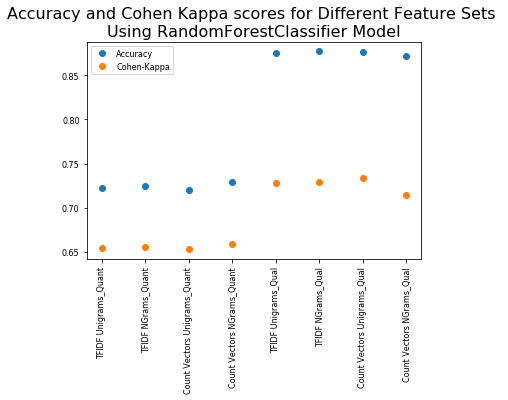

C:\Users\Kathleen Lange\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


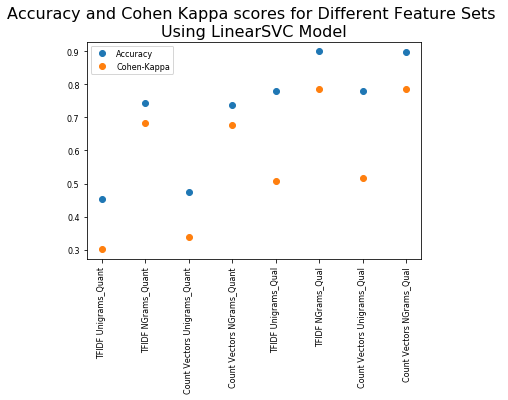

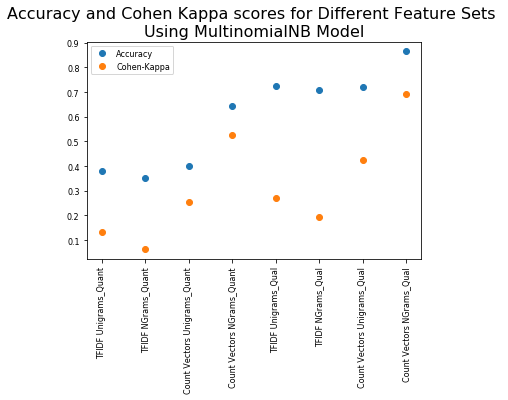

C:\Users\Kathleen Lange\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


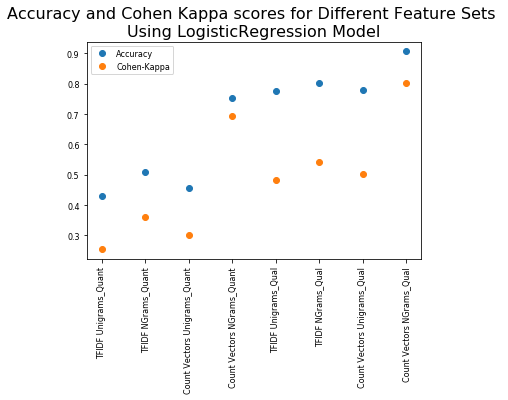

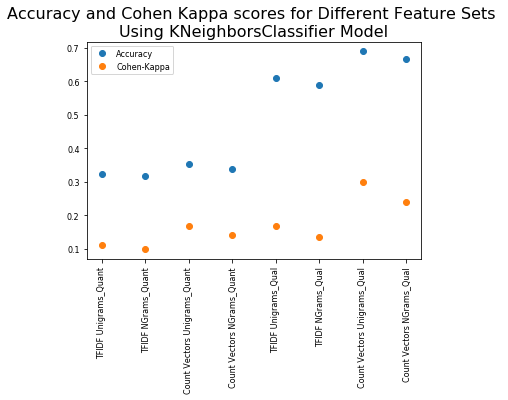

Wall time: 3h 34min 26s


In [15]:
%%time
# give each model the default parameters to first compare classifiers
# once best classifier is chosen will perform parameter optimization
models = [RandomForestClassifier(), LinearSVC(), MultinomialNB(), 
          LogisticRegression(multi_class='auto'), KNeighborsClassifier(n_neighbors=10)]
    
for mod in models:
    score_models(mod)

The last classifier was for K-Nearest-Neighbors which I gave a n_neighbors value of 10 to. This only works for the quantitative labels because it is equal to the number of classes. There are only 3 classes for the qualitative labels so I have to re-create the classifier graph for those feature sets.

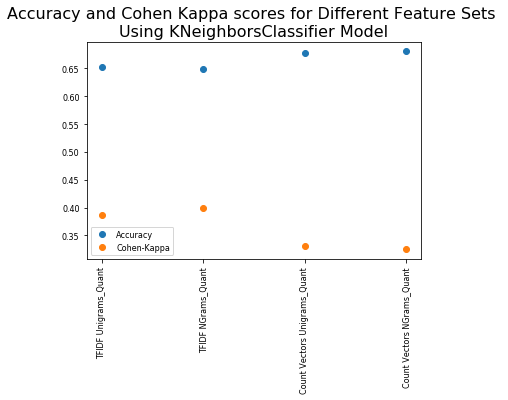

In [16]:
scores = []
scores.append(train_model(KNeighborsClassifier(n_neighbors=3), com_train_feats, com_ytrain_2, com_test_feats, com_ytest_2))
scores.append(train_model(KNeighborsClassifier(n_neighbors=3), n_com_train_feats, com_ytrain_2, n_com_test_feats, com_ytest_2))
scores.append(train_model(KNeighborsClassifier(n_neighbors=3), com_xtrain_count, com_ytrain_2, com_xtest_count, com_ytest_2))
scores.append(train_model(KNeighborsClassifier(n_neighbors=3), n_com_xtrain_count, com_ytrain_2, n_com_xtest_count, com_ytest_2))

score_names = ['TFIDF Unigrams_Quant', 'TFIDF NGrams_Quant', 
               'Count Vectors Unigrams_Quant', 'Count Vectors NGrams_Quant', 
               'TFIDF Unigrams_Qual', 'TFIDF NGrams_Qual',
               'Count Vectors Unigrams_Qual', 'Count Vectors NGrams_Qual']
    
plt.plot(scores, 'o')
plt.legend(['Accuracy', 'Cohen-Kappa'])
plt.xticks(range(4), score_names, rotation=90)
plt.title('Accuracy and Cohen Kappa scores for Different Feature Sets \nUsing {0} Model'.format(type(KNeighborsClassifier()).__name__))
plt.show()

## Cross Validation

From the above plots the RandomForest model and the LinearSVC (support vector machine) models performed the best. Also, the feature sets that performed best were the count and TFIDF features that included N-grams for the qualitative labels. Next, I will perform cross-validation with only these two feature sets and classifiers to choose the final best classifier.

In [17]:
def clf_chooser(features, labels):
    # code from here: https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f
    models = [RandomForestClassifier(n_jobs=-1), LinearSVC()]

    CV = 5
    cv_df = pd.DataFrame(index=range(CV * len(models)))
    entries = []

    for model in models:
        model_name = model.__class__.__name__
        accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
        for fold_idx, accuracy in enumerate(accuracies):
            entries.append((model_name, fold_idx, accuracy))

    cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
    
    fig, ax = plt.subplots(figsize=(12,5), sharex=True)
    sns.boxplot(x='model_name', y='accuracy', data=cv_df)
    sns.stripplot(x='model_name', y='accuracy', data=cv_df, size=6, jitter=True, edgecolor="gray", linewidth=1)
    ax.set_xlabel('Model Name')
    ax.set_ylabel('Accuracy')
    plt.xticks(rotation=70)
    plt.title('Cross Validation Accuracies by Classifier Type', fontsize=14)
    plt.show()
        
    return

C:\Users\Kathleen Lange\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Kathleen Lange\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Kathleen Lange\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Kathleen Lange\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Kathleen Lange\Anaconda3\lib\si

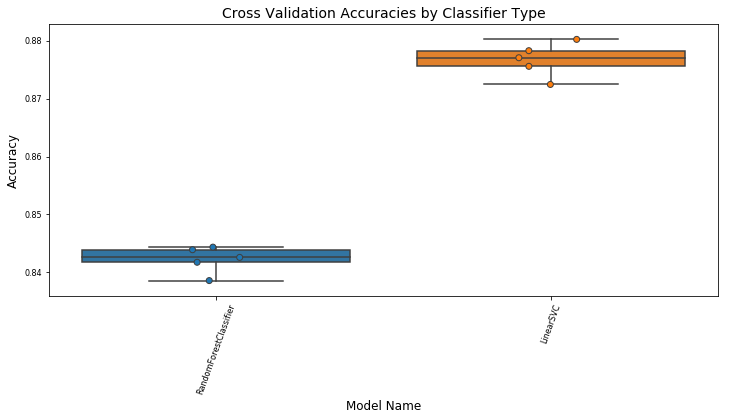

C:\Users\Kathleen Lange\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Kathleen Lange\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Kathleen Lange\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Kathleen Lange\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Kathleen Lange\Anaconda3\lib\si

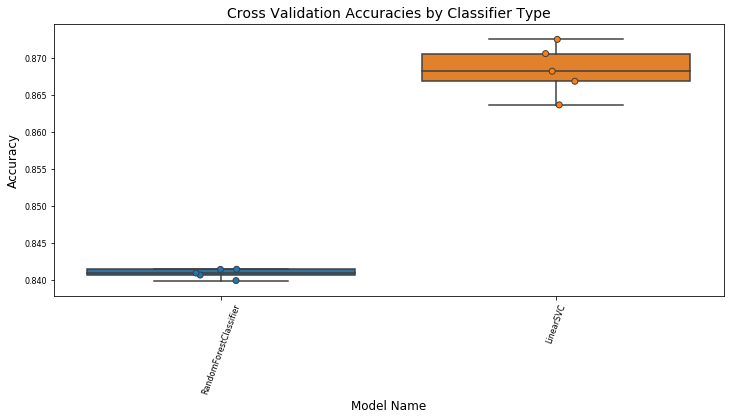

Wall time: 1h 22min 2s


In [18]:
%%time
clf_chooser(n_com_train_feats, com_ytrain_2)
clf_chooser(n_com_xtrain_count, com_ytrain_2)

The top graph shows the 5-fold cross validation using both RandomForest and LinearSVC (support vector machine) for the TFIDF features that included uni-, bi-, and tri-grams. The lower graph shows a similar cross validation but for the feature sets of just using frequency counts of the uni-, bi-, and tri-grams. The results between the two different feature sets were almost identical, in both cases the LinearSVC outperformed the RandomForest classifier. Therefore, I will choose the LinearSVC model as my final model to do my classifications on the dataset. Also, the two different feature sets performed very similarly, but the TFIDF features were consistently about 0.5-1% more accurate than the count features. I will use TFIDF for my final feature set.

In total, the four cross validations took almost an hour to complete. I do not think that tri-grams help that much in improving the classification accuracy and by removing them it could help reduce dimensionality and speed up training. To test this theory I will do the cross-validation again with just uni- and bi-grams to see if I can use these feature sets moving forward.

C:\Users\Kathleen Lange\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Kathleen Lange\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Kathleen Lange\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Kathleen Lange\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Kathleen Lange\Anaconda3\lib\si

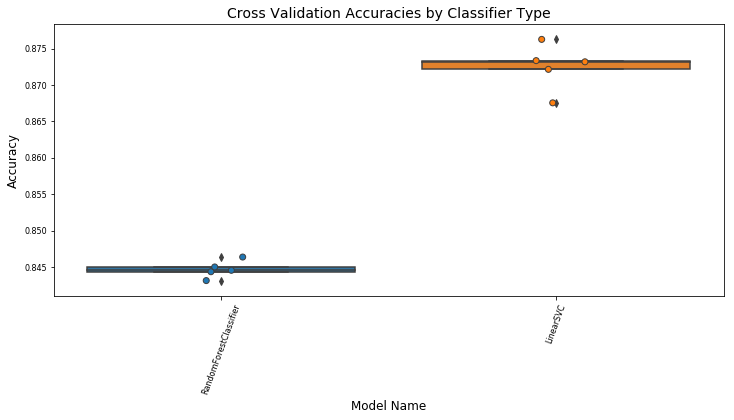

C:\Users\Kathleen Lange\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Kathleen Lange\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Kathleen Lange\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Kathleen Lange\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Kathleen Lange\Anaconda3\lib\si

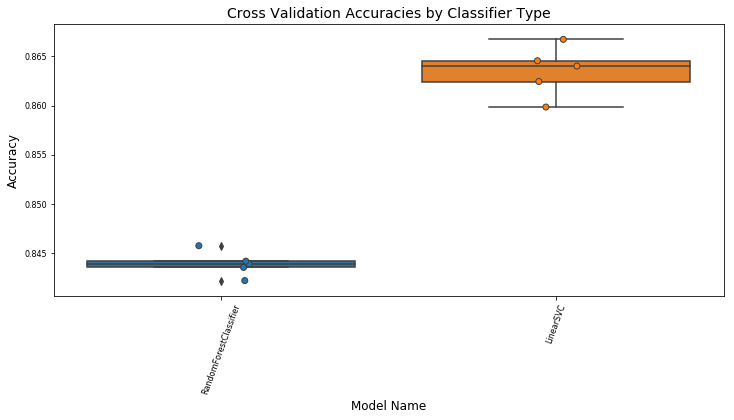

Wall time: 40min 17s


In [19]:
%%time
clf_chooser(train_feats_bigrams, com_ytrain_2)
clf_chooser(train_counts_bigrams, com_ytrain_2)

The results above show very similar results to the previous two graphs. The LinearSVC was still more accurate than the RandomForest model. Also, the TFIDF features produced slightly more accurate results than the count features. By removing tri-grams from the feature sets the accuracy of the model decreased about 0.5-1% overall. However, this is less than the spread of the cross-validation so it seems fairly insignificant. Also, by removing tri-grams it decreased the training time by a little more than half from an hour to 27 minutes. Therefore, I will just use uni- and bi-grams for my feature set moving forward.

The warnings produced during this cross validation show that one of the models for each graph did not converge for the LinearSVC classifier. By increased the max_iter parameter this problem can be solved.

## Parameter Optimization

Now that the classifier and feature set have been selected, I work on optimizing the classifier parameters. The LinearSVC classifier is a subset of a support vector machine that is a classifier using a linear kernel. Since I have already chosen the linear kernel, the only other parameter to optimize is the penalty parameter C. This parameter determines how close to the linear delineation line (the error term) the support vectors can be. The trade-off between smaller and larger values are the training times required along with how many misclassifications are acceptable.

Next, I look at the class weights. I do not have evenly distributed classes. The positive reviews are much more common than both the negative and neutral reviews. Therefore, I will set the class weights parameter to 'balanced'. This gives a weight to each of the classes dependent on the frequency of occurance. 

In [20]:
parameters = {'C':[.01, .1, 1, 10, 100]}
clf = GridSearchCV(LinearSVC(max_iter=1000, class_weight='balanced'), parameters, cv=5, n_jobs=-1)
clf.fit(train_feats_bigrams, com_ytrain_2)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LinearSVC(C=1.0, class_weight='balanced', dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [0.01, 0.1, 1, 10, 100]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=0)

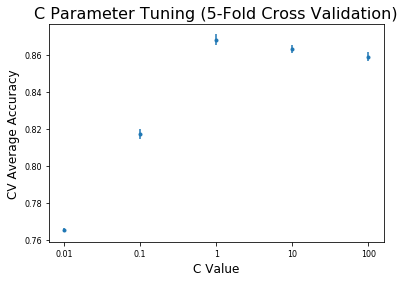

In [21]:
fig, ax = plt.subplots()
ax.errorbar([str(i) for i in clf.cv_results_['param_C']],
            clf.cv_results_['mean_test_score'], 
            yerr=clf.cv_results_['std_test_score'],
            fmt='.',)
ax.set(title='C Parameter Tuning (5-Fold Cross Validation)', ylabel='CV Average Accuracy', xlabel='C Value')
plt.show()

The best value for C is the default of C=1. This is where the mean accuracy of the 5-fold cross validation was the greatest. The spread of the accuracies was very minimal too which indicates the model's stability.

# Build & Test Models

## Drugs.com Training Set

Build the model using the LinearSVC classifier, the qualitative ratings and the TFIDF uni- plus bi-gram features. I use the Drugs.com dataset to train the model because it has almost 40 times the number of reviews as does the Drugslib.com training and testing sets combined.

In [22]:
LSVC_TFIDF_model = LinearSVC(max_iter=1000, class_weight='balanced', random_state=42).fit(train_feats_bigrams, com_ytrain_2)

# save model and fit vectorizer for use in subsequent analysis
with open('./clf_model.pkl', 'wb') as f:
    pickle.dump(LSVC_TFIDF_model, f)
    pickle.dump(vectorizer_2, f)

Make predictons on Drugs.com test set, and all of the Drugslib.com set of data. Use a confusion matrix and classification reports to visualize classification metrics.

In [23]:
def plot_confusion_matrix(cm, normalize=True, title='Confusion Matrix', cmap=plt.cm.Blues):
# code from this example: 
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
   
    classes = ['negative', 'nuetral', 'positive']
    np.set_printoptions(precision=2)

    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.1%' if normalize else 'd' # print 2 decimals if normalize, else print integer value
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()
    
    return

In [24]:
def plot_classification_report(cr, title, cmap=plt.cm.Blues):
    # code based on this example:
    # https://stackoverflow.com/questions/28200786/how-to-plot-scikit-learn-classification-report/31689645#31689645

    classes = ['negative', 'nuetral', 'positive']
    lines = cr.split('\n')
    plotMat = []
    for line in lines[2 : (len(lines) - 5)]:        
        t = line.split()       
        v = [float(x) for x in t[1: len(t)-1]]
        plotMat.append(v)
    
    plt.imshow(plotMat, interpolation='nearest', cmap=cmap)
    
    plt.title(title)
    plt.colorbar()
    
    x_tick_marks = np.arange(3)
    y_tick_marks = np.arange(len(classes))
    plt.xticks(x_tick_marks, ['precision', 'recall', 'f1-score'], rotation=90)
    plt.yticks(y_tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('Classes')
    plt.xlabel('Measures') 
    plt.show()
    
    return

Use the Drugs.com training set model to make predictions about the Drugs.com testing set.

Accuracy: 89.2%
Cohen-Kappa: 77.9%


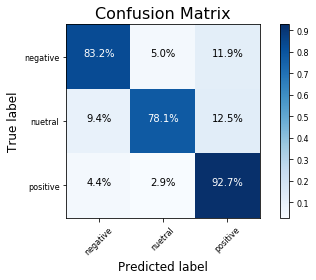

              precision    recall  f1-score   support

           1       0.86      0.83      0.84     13749
           2       0.64      0.78      0.70      3908
           3       0.94      0.93      0.93     35543

   micro avg       0.89      0.89      0.89     53200
   macro avg       0.81      0.85      0.83     53200
weighted avg       0.90      0.89      0.89     53200



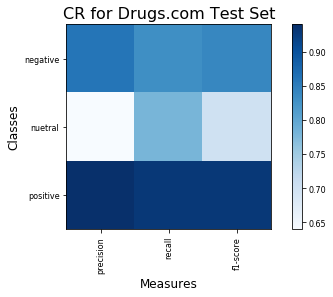

In [25]:
# make predictions
drugscom_test_preds = LSVC_TFIDF_model.predict(test_feats_bigrams)

# print overall metrics
acc = accuracy_score(drugscom_test_preds, com_ytest_2)
ck_score = cohen_kappa_score(com_ytest_2, drugscom_test_preds) 
print('Accuracy: {0:.1%}\nCohen-Kappa: {1:.1%}'.format(acc, ck_score))

# show confusion matrix
cm_drugscom_test = confusion_matrix(drugscom_test_preds, com_ytest_2)
plot_confusion_matrix(cm_drugscom_test, normalize=True)

# show classification report
drugscom_test_classrpt = classification_report(drugscom_test_preds, com_ytest_2)
print(drugscom_test_classrpt)
plot_classification_report(drugscom_test_classrpt, 'CR for Drugs.com Test Set')

The model was 89.2% accurate with a Cohen Kappa score of 77.9%. This is a very decent classifier for the same source and because the balance of classes between the training and testing sets were constant. 

Next I will see how the model trained on the Drugs.com source generalizes to a different source, Drugslib.com. The Drugslib.com dataset has three different types of reviews though, benefits, side effects and comments. At first I see how the classifier predicts each of the different types of review separately, then I combine them all into one big review and see how that compares.

In [26]:
def model_testing(model, vect, reviews, actuals):
    # create features
    features = vect.transform(reviews)

    # make predictions
    predictions = model.predict(features)

    # print overall metrics
    acc = accuracy_score(predictions, actuals)
    ck_score = cohen_kappa_score(predictions, actuals) 
    print('Accuracy: {0:.1%}\nCohen-Kappa: {1:.1%}'.format(acc, ck_score))
    
    # show confusion matrix
    cm = confusion_matrix(predictions, actuals)
    plot_confusion_matrix(cm, normalize=True)

    # show classification report
    cr = classification_report(predictions, actuals)
    print(cr)
    plot_classification_report(cr, 'Classification Report')
    
    return

Accuracy: 71.0%
Cohen-Kappa: 33.8%


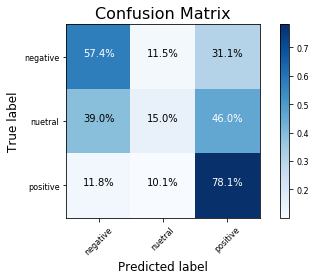

              precision    recall  f1-score   support

           1       0.49      0.57      0.53       772
           2       0.07      0.15      0.10       213
           3       0.88      0.78      0.83      3147

   micro avg       0.71      0.71      0.71      4132
   macro avg       0.48      0.50      0.49      4132
weighted avg       0.77      0.71      0.73      4132



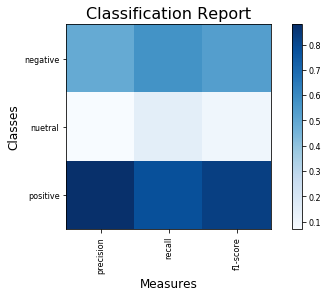

Accuracy: 63.6%
Cohen-Kappa: 29.3%


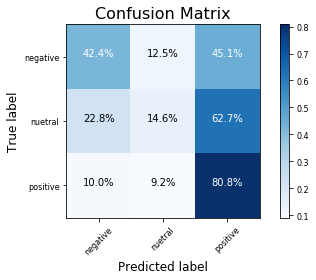

              precision    recall  f1-score   support

           1       0.66      0.42      0.52      1386
           2       0.09      0.15      0.11       268
           3       0.72      0.81      0.76      2478

   micro avg       0.64      0.64      0.64      4132
   macro avg       0.49      0.46      0.46      4132
weighted avg       0.66      0.64      0.64      4132



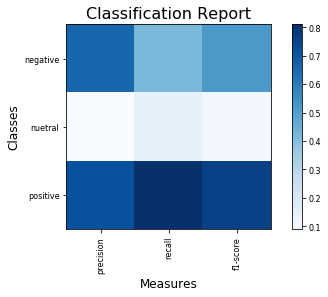

Accuracy: 64.5%
Cohen-Kappa: 18.1%


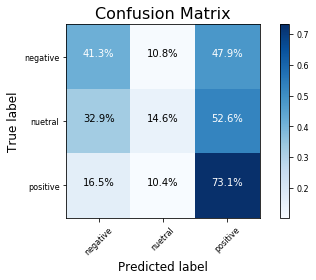

              precision    recall  f1-score   support

           1       0.33      0.41      0.37       724
           2       0.07      0.15      0.09       213
           3       0.84      0.73      0.78      3195

   micro avg       0.65      0.65      0.65      4132
   macro avg       0.41      0.43      0.41      4132
weighted avg       0.71      0.65      0.67      4132



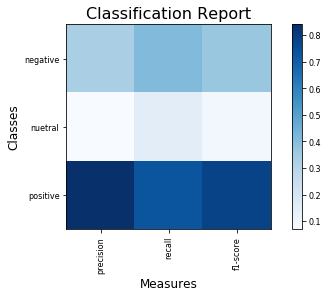

Accuracy: 64.9%
Cohen-Kappa: 19.2%


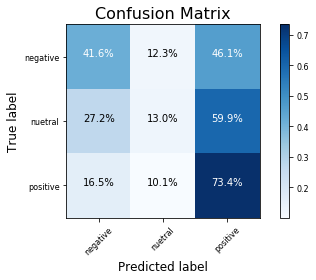

              precision    recall  f1-score   support

           1       0.37      0.42      0.39       791
           2       0.05      0.13      0.07       162
           3       0.83      0.73      0.78      3179

   micro avg       0.65      0.65      0.65      4132
   macro avg       0.42      0.43      0.41      4132
weighted avg       0.71      0.65      0.68      4132



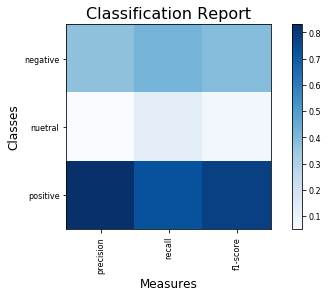

In [27]:
model_testing(LSVC_TFIDF_model, vectorizer_2, df_lib['all_reviews'], lib_all_labels)
model_testing(LSVC_TFIDF_model, vectorizer_2, df_lib['sideEffects_clean'], lib_all_labels)
model_testing(LSVC_TFIDF_model, vectorizer_2, df_lib['benefits_clean'], lib_all_labels)
model_testing(LSVC_TFIDF_model, vectorizer_2, df_lib['comments_clean'], lib_all_labels)

When looking at all of the reviews combined, the model was 70.9% accurate, however, the Cohen Kappa score was only 33.7%. From the confusion matrix, the model was much better at classifying positive reviews compared to ones that were negative. It was really bad at classifying neutral reviews.

For the side effects reviews, the results were very similar to those of all the reviews. Total accuracy of 63.7% with a CK score of 29.3%. Positive reviews were also the easiest to classify with neutral reviews being the hardest. The benefits and comments specific reviews matched each other well in regards to the classification metrics and continued to be worse than all the reviews combined and just the side effects. 

## Drugslib.com Training Set

Next, I will use the same model parameters to see if building the model from the Drugslib.com source training set makes any improvement in the overall classification. I will test this model on both the Drugslib.com testing set as well as the Drugs.com testing set.

In [28]:
vectorizer_2_lib = TfidfVectorizer(min_df=3, ngram_range=(1, 2))
lib_train_feats_bigrams = vectorizer_2_lib.fit_transform(lib_train['all_reviews'])
lib_test_feats_bigrams = vectorizer_2_lib.transform(lib_test['all_reviews'])

In [29]:
LSVC_TFIDF_model_lib = LinearSVC(max_iter=1000, class_weight='balanced', random_state=42).fit(lib_train_feats_bigrams, lib_ytrain)

Accuracy: 70.8%
Cohen-Kappa: 37.0%


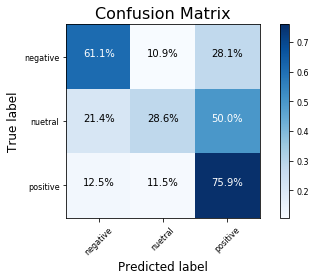

              precision    recall  f1-score   support

           1       0.56      0.61      0.58       221
           2       0.10      0.29      0.14        42
           3       0.88      0.76      0.81       773

   micro avg       0.71      0.71      0.71      1036
   macro avg       0.51      0.55      0.51      1036
weighted avg       0.78      0.71      0.74      1036



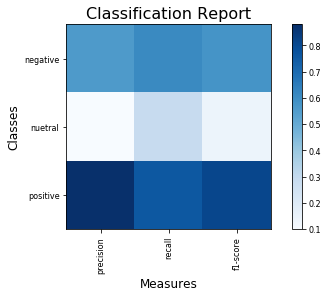

Accuracy: 64.9%
Cohen-Kappa: 26.7%


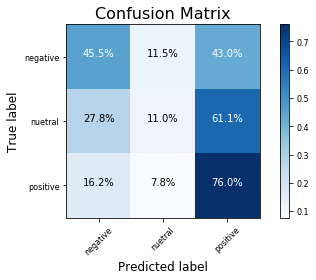

              precision    recall  f1-score   support

           1       0.52      0.46      0.49     15360
           2       0.04      0.11      0.06      1876
           3       0.78      0.76      0.77     35964

   micro avg       0.65      0.65      0.65     53200
   macro avg       0.45      0.44      0.44     53200
weighted avg       0.68      0.65      0.66     53200



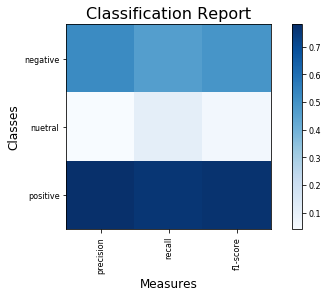

In [30]:
model_testing(LSVC_TFIDF_model_lib, vectorizer_2_lib, lib_test['all_reviews'], lib_ytest)
model_testing(LSVC_TFIDF_model_lib, vectorizer_2_lib, com_test['review_clean'], com_ytest_2)

Using the Drugslib.com as my training source, it classified with much less accurate results on both its own testing set and with regard to the Drugs.com testing set. This is probably due to the fact that this source has much less data overall.

## Drugs.com Condition Specific Subsets

Create condition specific models from the Drugs.com training set to see if the models can be transferred to different conditions within the same source. Also, test if the models are accurate when analyzing the same condition coming from a different source. This is an important step to look at because often there are condition specific words, or ways in using a word that may be different for different conditions. Different conditions may have different jargon which could potentially be treated differently by a classifier.

Confusion matrix, without normalization


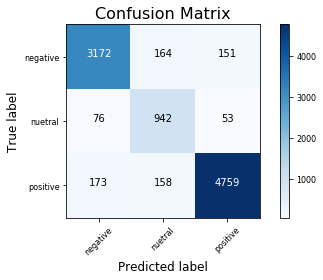

Confusion matrix, without normalization


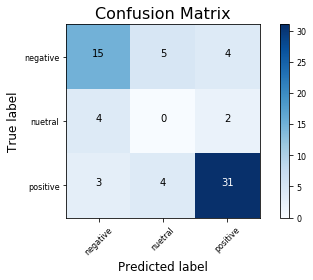

              precision    recall  f1-score   support

           1       0.93      0.91      0.92      3487
           2       0.75      0.88      0.81      1071
           3       0.96      0.93      0.95      5090

   micro avg       0.92      0.92      0.92      9648
   macro avg       0.88      0.91      0.89      9648
weighted avg       0.92      0.92      0.92      9648



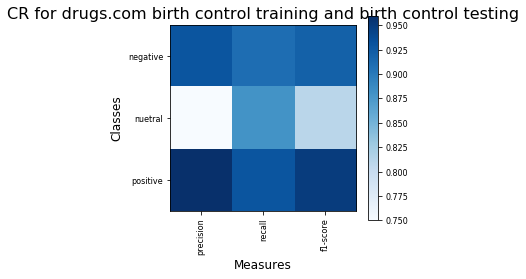

              precision    recall  f1-score   support

           1       0.68      0.62      0.65        24
           2       0.00      0.00      0.00         6
           3       0.84      0.82      0.83        38

   micro avg       0.68      0.68      0.68        68
   macro avg       0.51      0.48      0.49        68
weighted avg       0.71      0.68      0.69        68



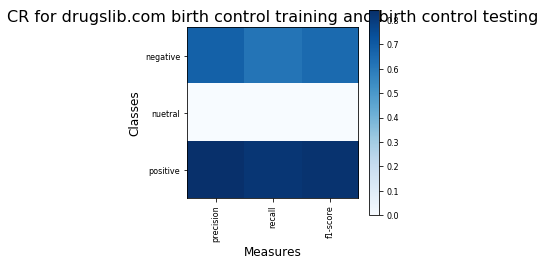

Modeling completed for training set birth control and testing set birth control
Confusion matrix, without normalization


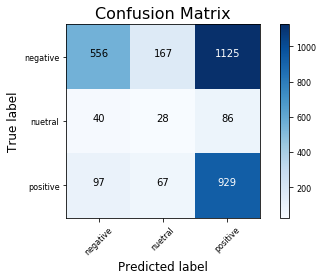

Confusion matrix, without normalization


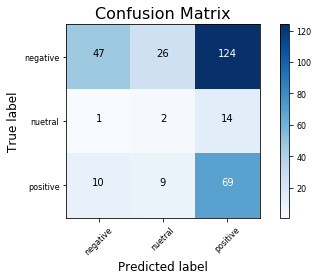

              precision    recall  f1-score   support

           1       0.80      0.30      0.44      1848
           2       0.11      0.18      0.13       154
           3       0.43      0.85      0.57      1093

   micro avg       0.49      0.49      0.49      3095
   macro avg       0.45      0.44      0.38      3095
weighted avg       0.64      0.49      0.47      3095



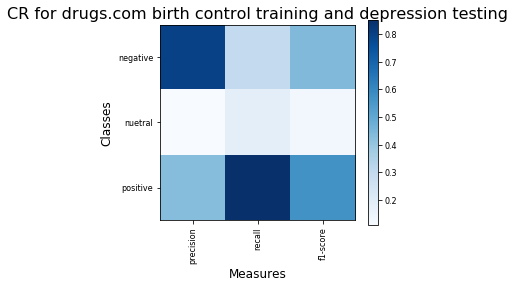

              precision    recall  f1-score   support

           1       0.81      0.24      0.37       197
           2       0.05      0.12      0.07        17
           3       0.33      0.78      0.47        88

   micro avg       0.39      0.39      0.39       302
   macro avg       0.40      0.38      0.30       302
weighted avg       0.63      0.39      0.38       302



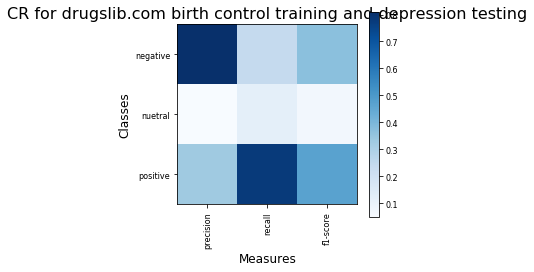

Modeling completed for training set birth control and testing set depression


C:\Users\Kathleen Lange\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Kathleen Lange\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:373: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


Confusion matrix, without normalization


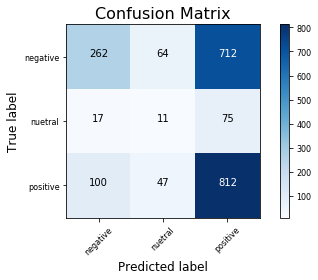

Confusion matrix, without normalization


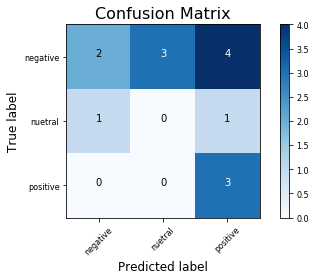

              precision    recall  f1-score   support

           1       0.69      0.25      0.37      1038
           2       0.09      0.11      0.10       103
           3       0.51      0.85      0.63       959

   micro avg       0.52      0.52      0.52      2100
   macro avg       0.43      0.40      0.37      2100
weighted avg       0.58      0.52      0.48      2100



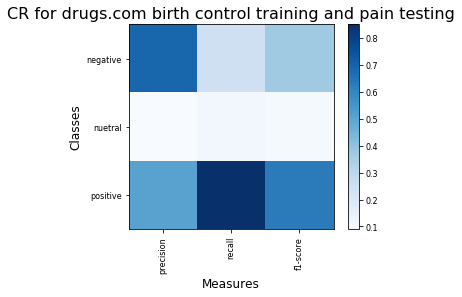

              precision    recall  f1-score   support

           1       0.67      0.22      0.33         9
           2       0.00      0.00      0.00         2
           3       0.38      1.00      0.55         3

   micro avg       0.36      0.36      0.36        14
   macro avg       0.35      0.41      0.29        14
weighted avg       0.51      0.36      0.33        14



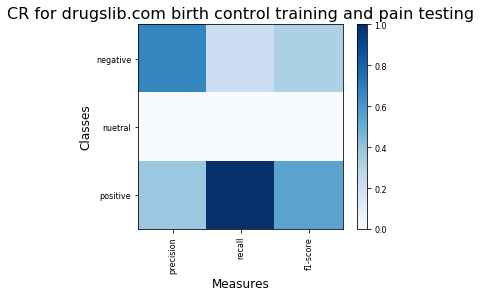

Modeling completed for training set birth control and testing set pain
Confusion matrix, without normalization


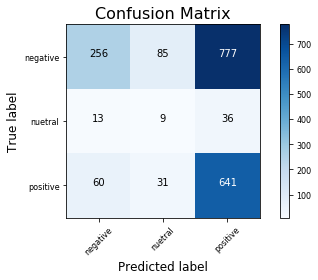

Confusion matrix, without normalization


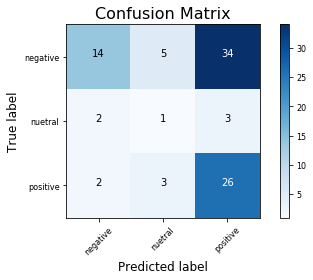

              precision    recall  f1-score   support

           1       0.78      0.23      0.35      1118
           2       0.07      0.16      0.10        58
           3       0.44      0.88      0.59       732

   micro avg       0.47      0.47      0.47      1908
   macro avg       0.43      0.42      0.35      1908
weighted avg       0.63      0.47      0.44      1908



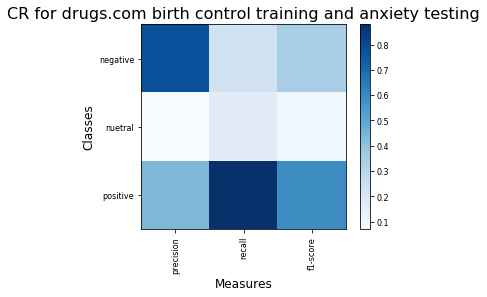

              precision    recall  f1-score   support

           1       0.78      0.26      0.39        53
           2       0.11      0.17      0.13         6
           3       0.41      0.84      0.55        31

   micro avg       0.46      0.46      0.46        90
   macro avg       0.43      0.42      0.36        90
weighted avg       0.61      0.46      0.43        90



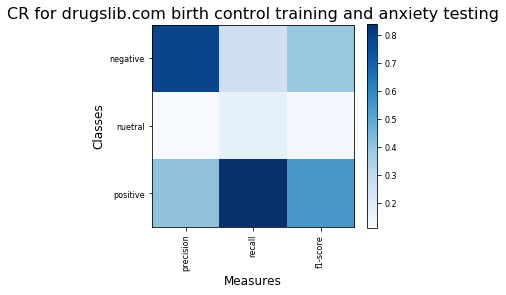

Modeling completed for training set birth control and testing set anxiety
Confusion matrix, without normalization


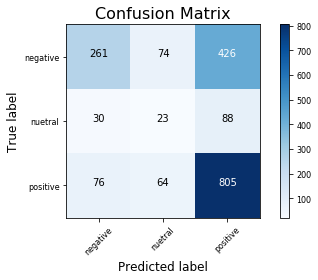

Confusion matrix, without normalization


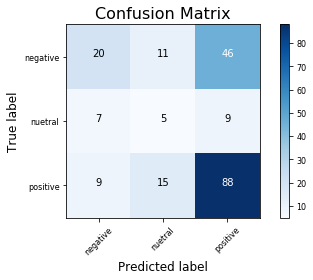

              precision    recall  f1-score   support

           1       0.71      0.34      0.46       761
           2       0.14      0.16      0.15       141
           3       0.61      0.85      0.71       945

   micro avg       0.59      0.59      0.59      1847
   macro avg       0.49      0.45      0.44      1847
weighted avg       0.62      0.59      0.57      1847



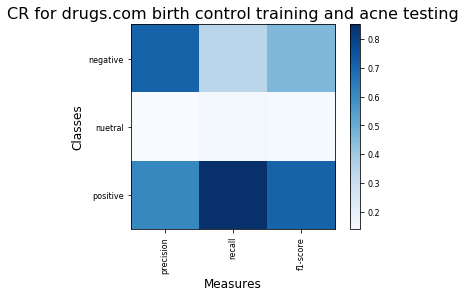

              precision    recall  f1-score   support

           1       0.56      0.26      0.35        77
           2       0.16      0.24      0.19        21
           3       0.62      0.79      0.69       112

   micro avg       0.54      0.54      0.54       210
   macro avg       0.44      0.43      0.41       210
weighted avg       0.55      0.54      0.52       210



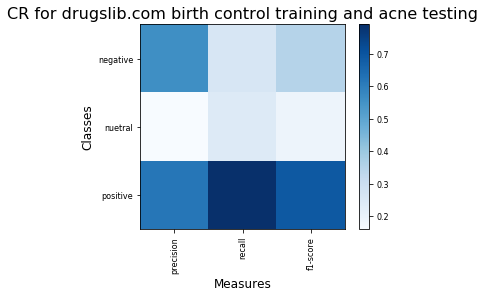

Modeling completed for training set birth control and testing set acne
Confusion matrix, without normalization


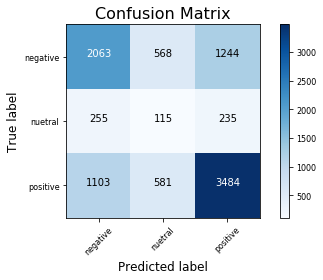

Confusion matrix, without normalization


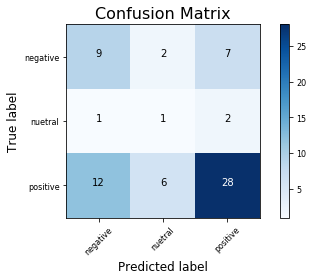

              precision    recall  f1-score   support

           1       0.60      0.53      0.57      3875
           2       0.09      0.19      0.12       605
           3       0.70      0.67      0.69      5168

   micro avg       0.59      0.59      0.59      9648
   macro avg       0.47      0.47      0.46      9648
weighted avg       0.62      0.59      0.60      9648



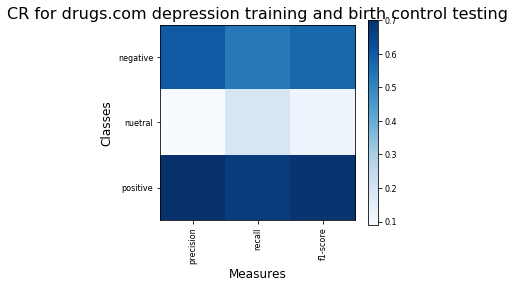

              precision    recall  f1-score   support

           1       0.41      0.50      0.45        18
           2       0.11      0.25      0.15         4
           3       0.76      0.61      0.67        46

   micro avg       0.56      0.56      0.56        68
   macro avg       0.43      0.45      0.43        68
weighted avg       0.63      0.56      0.58        68



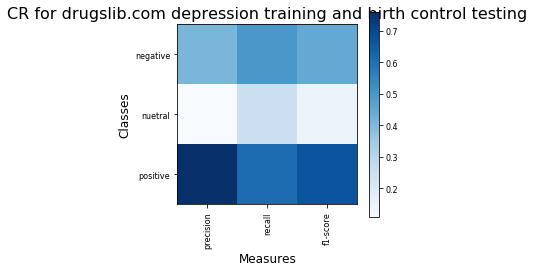

Modeling completed for training set depression and testing set birth control
Confusion matrix, without normalization


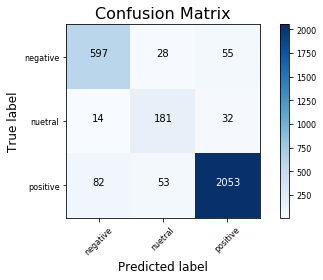

Confusion matrix, without normalization


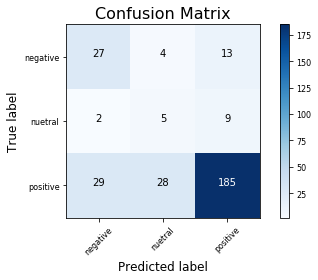

              precision    recall  f1-score   support

           1       0.86      0.88      0.87       680
           2       0.69      0.80      0.74       227
           3       0.96      0.94      0.95      2188

   micro avg       0.91      0.91      0.91      3095
   macro avg       0.84      0.87      0.85      3095
weighted avg       0.92      0.91      0.92      3095



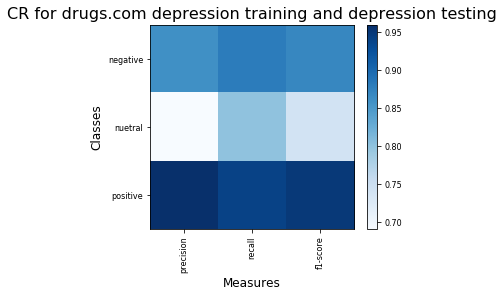

              precision    recall  f1-score   support

           1       0.47      0.61      0.53        44
           2       0.14      0.31      0.19        16
           3       0.89      0.76      0.82       242

   micro avg       0.72      0.72      0.72       302
   macro avg       0.50      0.56      0.51       302
weighted avg       0.79      0.72      0.75       302



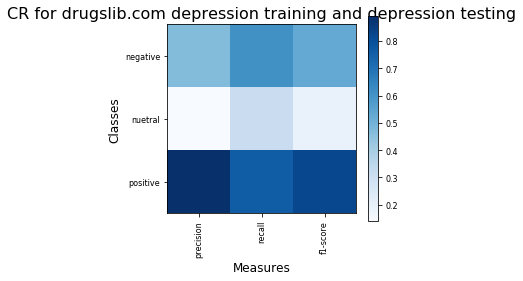

Modeling completed for training set depression and testing set depression


C:\Users\Kathleen Lange\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Kathleen Lange\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:373: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


Confusion matrix, without normalization


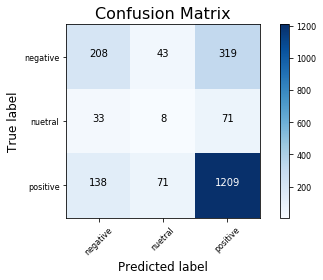

Confusion matrix, without normalization


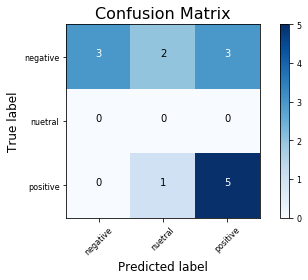

              precision    recall  f1-score   support

           1       0.55      0.36      0.44       570
           2       0.07      0.07      0.07       112
           3       0.76      0.85      0.80      1418

   micro avg       0.68      0.68      0.68      2100
   macro avg       0.46      0.43      0.44      2100
weighted avg       0.66      0.68      0.66      2100



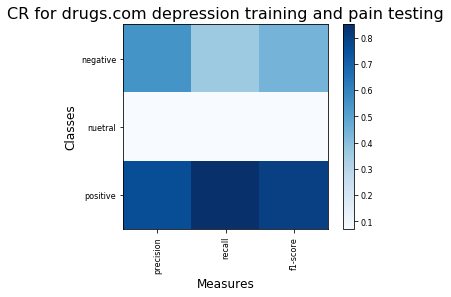

              precision    recall  f1-score   support

           1       1.00      0.38      0.55         8
           2       0.00      0.00      0.00         0
           3       0.62      0.83      0.71         6

   micro avg       0.57      0.57      0.57        14
   macro avg       0.54      0.40      0.42        14
weighted avg       0.84      0.57      0.62        14



C:\Users\Kathleen Lange\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


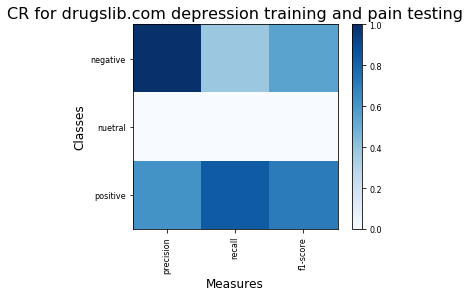

Modeling completed for training set depression and testing set pain
Confusion matrix, without normalization


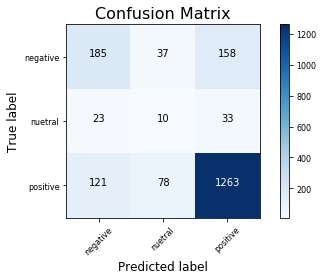

Confusion matrix, without normalization


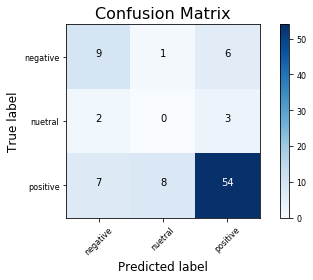

              precision    recall  f1-score   support

           1       0.56      0.49      0.52       380
           2       0.08      0.15      0.10        66
           3       0.87      0.86      0.87      1462

   micro avg       0.76      0.76      0.76      1908
   macro avg       0.50      0.50      0.50      1908
weighted avg       0.78      0.76      0.77      1908



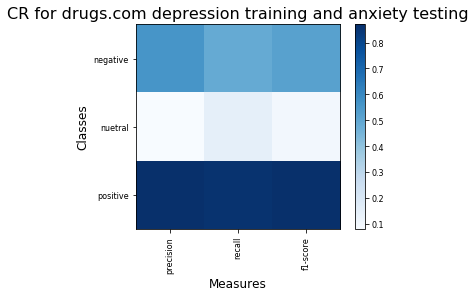

              precision    recall  f1-score   support

           1       0.50      0.56      0.53        16
           2       0.00      0.00      0.00         5
           3       0.86      0.78      0.82        69

   micro avg       0.70      0.70      0.70        90
   macro avg       0.45      0.45      0.45        90
weighted avg       0.75      0.70      0.72        90



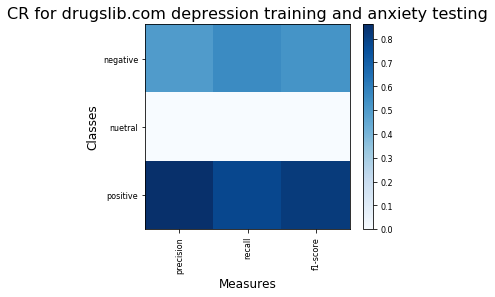

Modeling completed for training set depression and testing set anxiety
Confusion matrix, without normalization


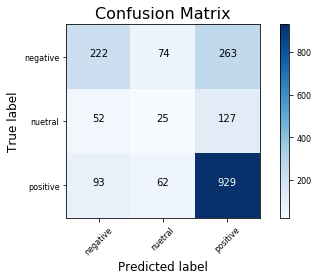

Confusion matrix, without normalization


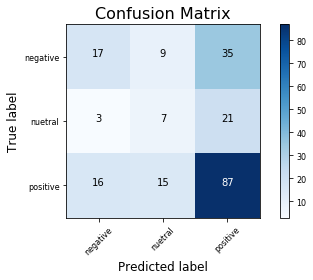

              precision    recall  f1-score   support

           1       0.60      0.40      0.48       559
           2       0.16      0.12      0.14       204
           3       0.70      0.86      0.77      1084

   micro avg       0.64      0.64      0.64      1847
   macro avg       0.49      0.46      0.46      1847
weighted avg       0.61      0.64      0.61      1847



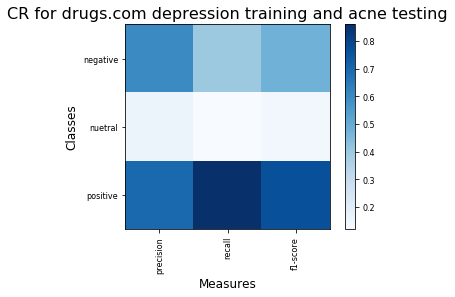

              precision    recall  f1-score   support

           1       0.47      0.28      0.35        61
           2       0.23      0.23      0.23        31
           3       0.61      0.74      0.67       118

   micro avg       0.53      0.53      0.53       210
   macro avg       0.44      0.41      0.41       210
weighted avg       0.51      0.53      0.51       210



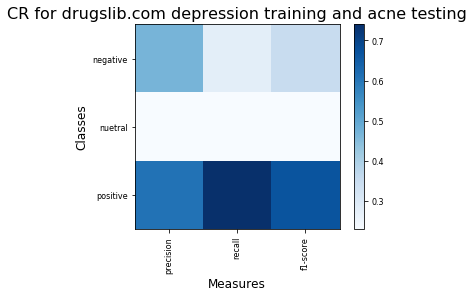

Modeling completed for training set depression and testing set acne
Confusion matrix, without normalization


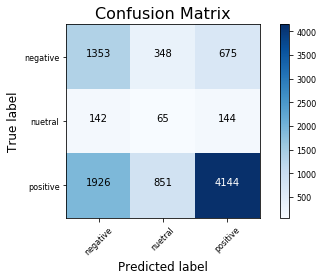

Confusion matrix, without normalization


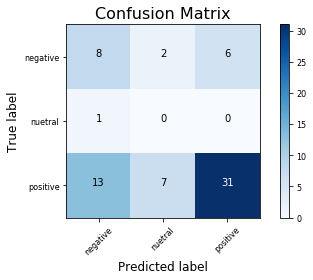

              precision    recall  f1-score   support

           1       0.40      0.57      0.47      2376
           2       0.05      0.19      0.08       351
           3       0.83      0.60      0.70      6921

   micro avg       0.58      0.58      0.58      9648
   macro avg       0.43      0.45      0.41      9648
weighted avg       0.70      0.58      0.62      9648



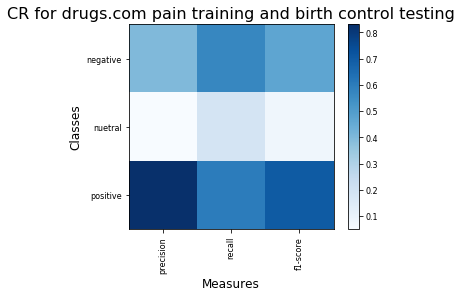

              precision    recall  f1-score   support

           1       0.36      0.50      0.42        16
           2       0.00      0.00      0.00         1
           3       0.84      0.61      0.70        51

   micro avg       0.57      0.57      0.57        68
   macro avg       0.40      0.37      0.38        68
weighted avg       0.71      0.57      0.63        68



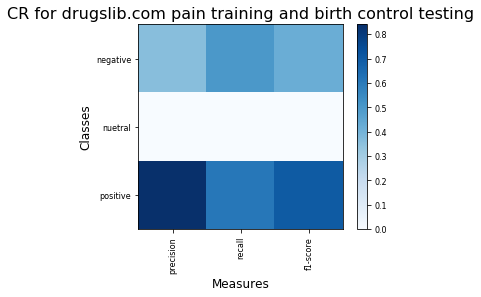

Modeling completed for training set pain and testing set birth control
Confusion matrix, without normalization


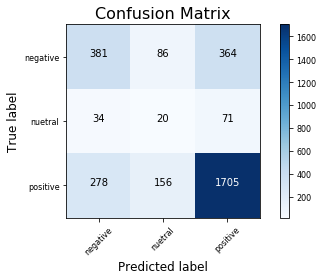

Confusion matrix, without normalization


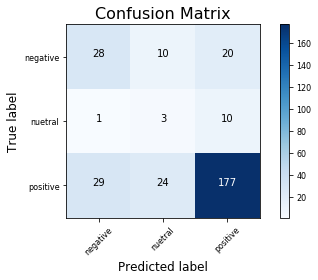

              precision    recall  f1-score   support

           1       0.55      0.46      0.50       831
           2       0.08      0.16      0.10       125
           3       0.80      0.80      0.80      2139

   micro avg       0.68      0.68      0.68      3095
   macro avg       0.47      0.47      0.47      3095
weighted avg       0.70      0.68      0.69      3095



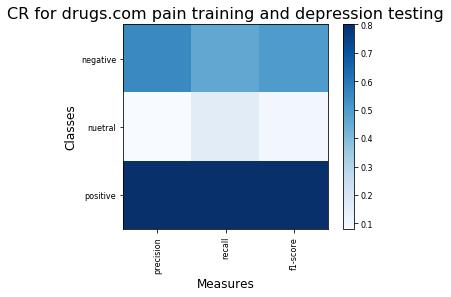

              precision    recall  f1-score   support

           1       0.48      0.48      0.48        58
           2       0.08      0.21      0.12        14
           3       0.86      0.77      0.81       230

   micro avg       0.69      0.69      0.69       302
   macro avg       0.47      0.49      0.47       302
weighted avg       0.75      0.69      0.72       302



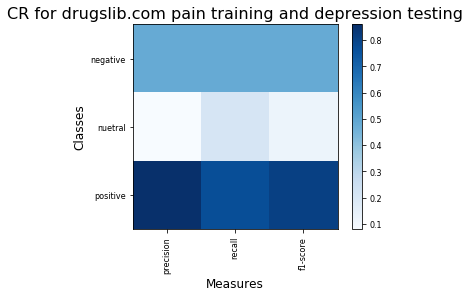

Modeling completed for training set pain and testing set depression


C:\Users\Kathleen Lange\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Kathleen Lange\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:373: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


Confusion matrix, without normalization


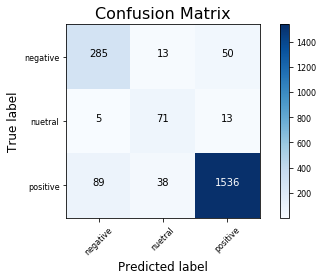

Confusion matrix, without normalization


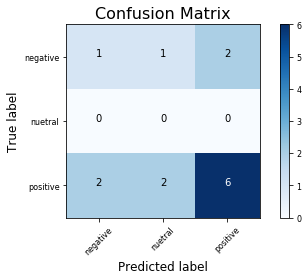

              precision    recall  f1-score   support

           1       0.75      0.82      0.78       348
           2       0.58      0.80      0.67        89
           3       0.96      0.92      0.94      1663

   micro avg       0.90      0.90      0.90      2100
   macro avg       0.76      0.85      0.80      2100
weighted avg       0.91      0.90      0.90      2100



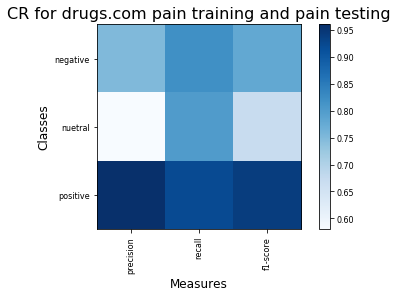

              precision    recall  f1-score   support

           1       0.33      0.25      0.29         4
           2       0.00      0.00      0.00         0
           3       0.75      0.60      0.67        10

   micro avg       0.50      0.50      0.50        14
   macro avg       0.36      0.28      0.32        14
weighted avg       0.63      0.50      0.56        14



C:\Users\Kathleen Lange\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


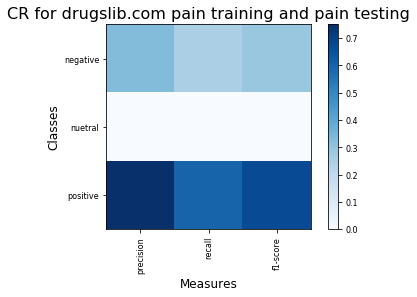

Modeling completed for training set pain and testing set pain
Confusion matrix, without normalization


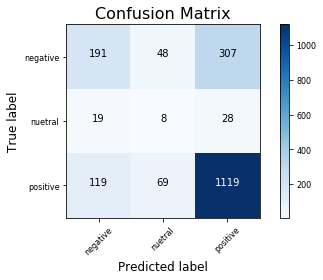

Confusion matrix, without normalization


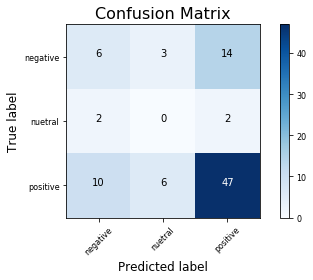

              precision    recall  f1-score   support

           1       0.58      0.35      0.44       546
           2       0.06      0.15      0.09        55
           3       0.77      0.86      0.81      1307

   micro avg       0.69      0.69      0.69      1908
   macro avg       0.47      0.45      0.45      1908
weighted avg       0.70      0.69      0.68      1908



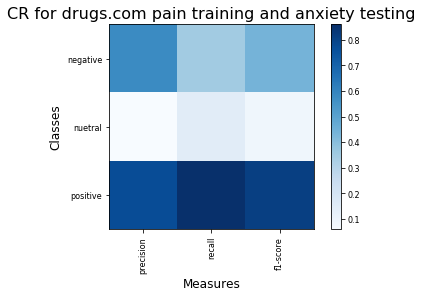

              precision    recall  f1-score   support

           1       0.33      0.26      0.29        23
           2       0.00      0.00      0.00         4
           3       0.75      0.75      0.75        63

   micro avg       0.59      0.59      0.59        90
   macro avg       0.36      0.34      0.35        90
weighted avg       0.61      0.59      0.60        90



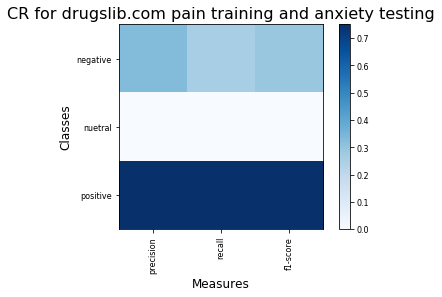

Modeling completed for training set pain and testing set anxiety
Confusion matrix, without normalization


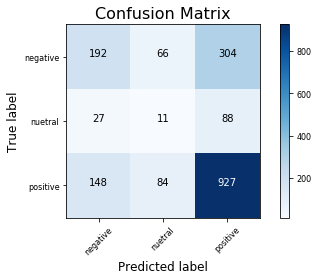

Confusion matrix, without normalization


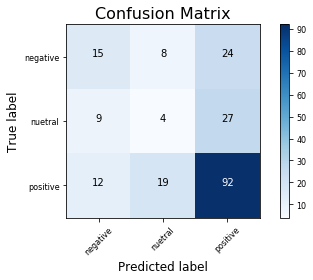

              precision    recall  f1-score   support

           1       0.52      0.34      0.41       562
           2       0.07      0.09      0.08       126
           3       0.70      0.80      0.75      1159

   micro avg       0.61      0.61      0.61      1847
   macro avg       0.43      0.41      0.41      1847
weighted avg       0.60      0.61      0.60      1847



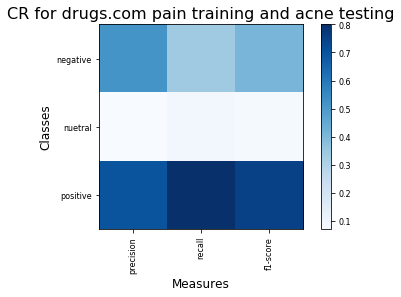

              precision    recall  f1-score   support

           1       0.42      0.32      0.36        47
           2       0.13      0.10      0.11        40
           3       0.64      0.75      0.69       123

   micro avg       0.53      0.53      0.53       210
   macro avg       0.40      0.39      0.39       210
weighted avg       0.49      0.53      0.51       210



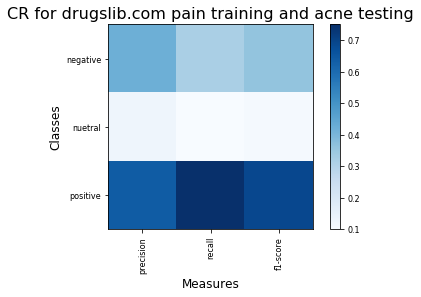

Modeling completed for training set pain and testing set acne
Confusion matrix, without normalization


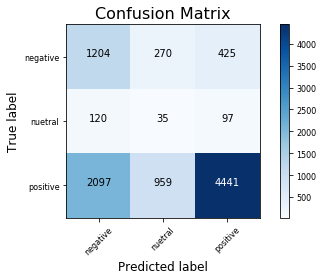

Confusion matrix, without normalization


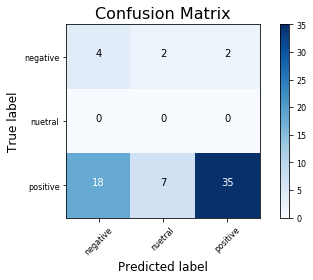

              precision    recall  f1-score   support

           1       0.35      0.63      0.45      1899
           2       0.03      0.14      0.05       252
           3       0.89      0.59      0.71      7497

   micro avg       0.59      0.59      0.59      9648
   macro avg       0.42      0.46      0.40      9648
weighted avg       0.77      0.59      0.64      9648



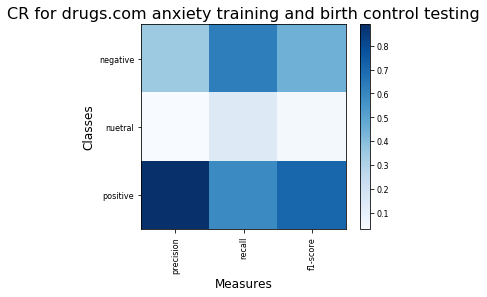

              precision    recall  f1-score   support

           1       0.18      0.50      0.27         8
           2       0.00      0.00      0.00         0
           3       0.95      0.58      0.72        60

   micro avg       0.57      0.57      0.57        68
   macro avg       0.38      0.36      0.33        68
weighted avg       0.86      0.57      0.67        68



C:\Users\Kathleen Lange\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


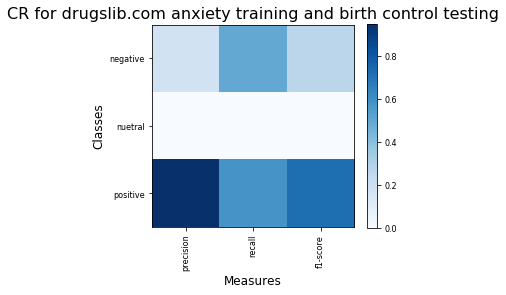

Modeling completed for training set anxiety and testing set birth control
Confusion matrix, without normalization


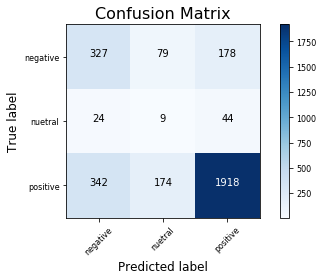

Confusion matrix, without normalization


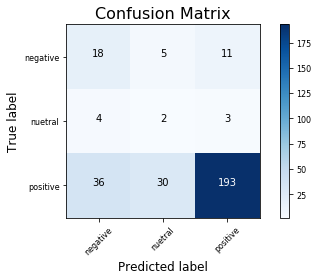

              precision    recall  f1-score   support

           1       0.47      0.56      0.51       584
           2       0.03      0.12      0.05        77
           3       0.90      0.79      0.84      2434

   micro avg       0.73      0.73      0.73      3095
   macro avg       0.47      0.49      0.47      3095
weighted avg       0.79      0.73      0.76      3095



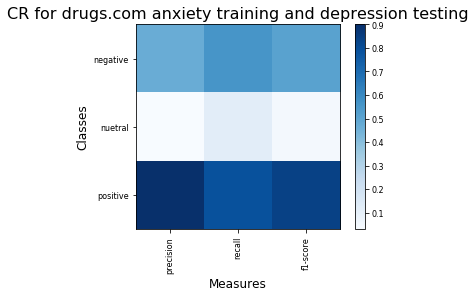

              precision    recall  f1-score   support

           1       0.31      0.53      0.39        34
           2       0.05      0.22      0.09         9
           3       0.93      0.75      0.83       259

   micro avg       0.71      0.71      0.71       302
   macro avg       0.43      0.50      0.44       302
weighted avg       0.84      0.71      0.76       302



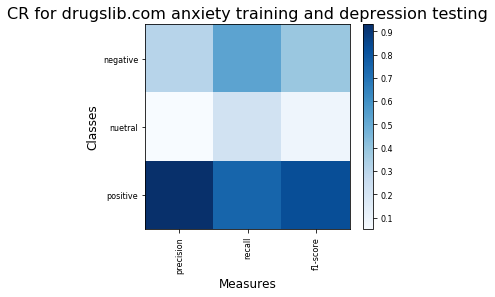

Modeling completed for training set anxiety and testing set depression


C:\Users\Kathleen Lange\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Kathleen Lange\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:373: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


Confusion matrix, without normalization


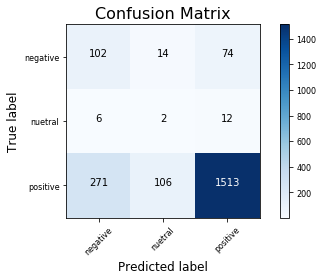

Confusion matrix, without normalization


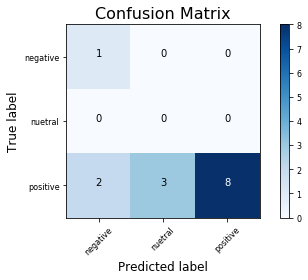

              precision    recall  f1-score   support

           1       0.27      0.54      0.36       190
           2       0.02      0.10      0.03        20
           3       0.95      0.80      0.87      1890

   micro avg       0.77      0.77      0.77      2100
   macro avg       0.41      0.48      0.42      2100
weighted avg       0.88      0.77      0.81      2100



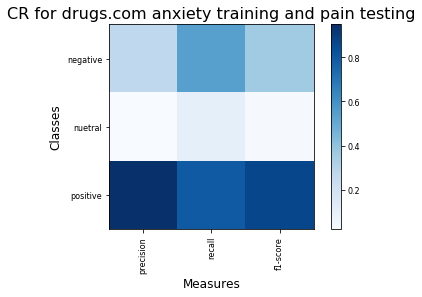

              precision    recall  f1-score   support

           1       0.33      1.00      0.50         1
           2       0.00      0.00      0.00         0
           3       1.00      0.62      0.76        13

   micro avg       0.64      0.64      0.64        14
   macro avg       0.44      0.54      0.42        14
weighted avg       0.95      0.64      0.74        14



C:\Users\Kathleen Lange\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


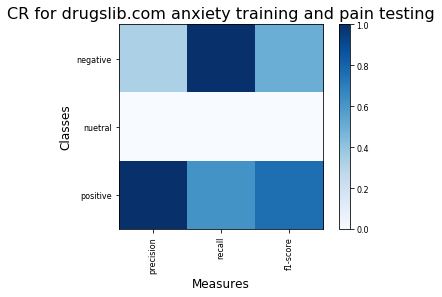

Modeling completed for training set anxiety and testing set pain
Confusion matrix, without normalization


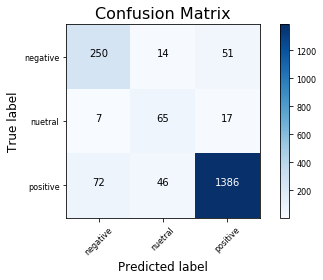

Confusion matrix, without normalization


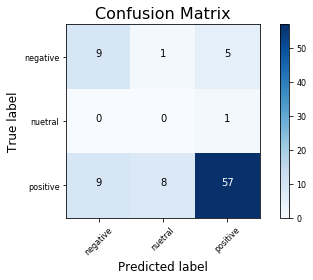

              precision    recall  f1-score   support

           1       0.76      0.79      0.78       315
           2       0.52      0.73      0.61        89
           3       0.95      0.92      0.94      1504

   micro avg       0.89      0.89      0.89      1908
   macro avg       0.74      0.82      0.77      1908
weighted avg       0.90      0.89      0.90      1908



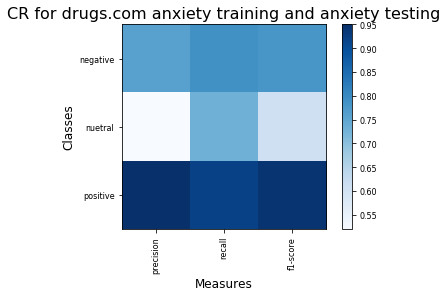

              precision    recall  f1-score   support

           1       0.50      0.60      0.55        15
           2       0.00      0.00      0.00         1
           3       0.90      0.77      0.83        74

   micro avg       0.73      0.73      0.73        90
   macro avg       0.47      0.46      0.46        90
weighted avg       0.83      0.73      0.78        90



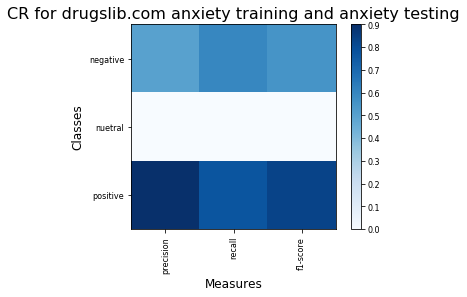

Modeling completed for training set anxiety and testing set anxiety
Confusion matrix, without normalization


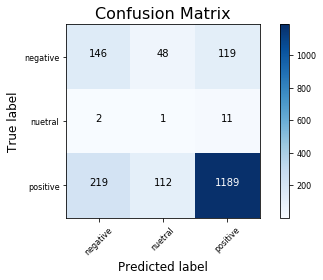

Confusion matrix, without normalization


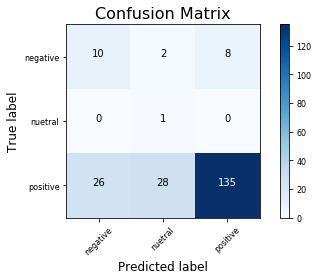

              precision    recall  f1-score   support

           1       0.40      0.47      0.43       313
           2       0.01      0.07      0.01        14
           3       0.90      0.78      0.84      1520

   micro avg       0.72      0.72      0.72      1847
   macro avg       0.44      0.44      0.43      1847
weighted avg       0.81      0.72      0.76      1847



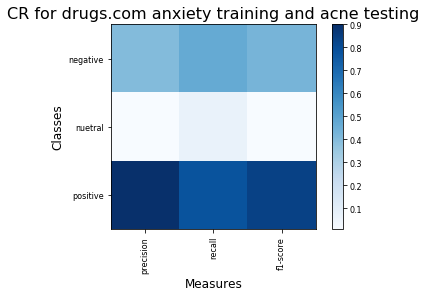

              precision    recall  f1-score   support

           1       0.28      0.50      0.36        20
           2       0.03      1.00      0.06         1
           3       0.94      0.71      0.81       189

   micro avg       0.70      0.70      0.70       210
   macro avg       0.42      0.74      0.41       210
weighted avg       0.88      0.70      0.77       210



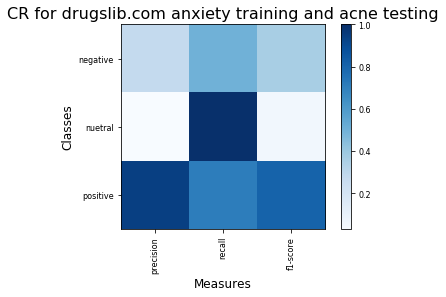

Modeling completed for training set anxiety and testing set acne
Confusion matrix, without normalization


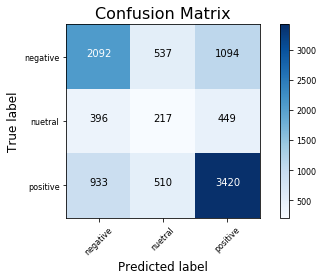

Confusion matrix, without normalization


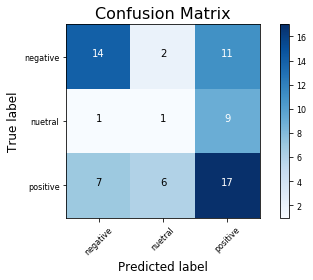

              precision    recall  f1-score   support

           1       0.61      0.56      0.59      3723
           2       0.17      0.20      0.19      1062
           3       0.69      0.70      0.70      4863

   micro avg       0.59      0.59      0.59      9648
   macro avg       0.49      0.49      0.49      9648
weighted avg       0.60      0.59      0.60      9648



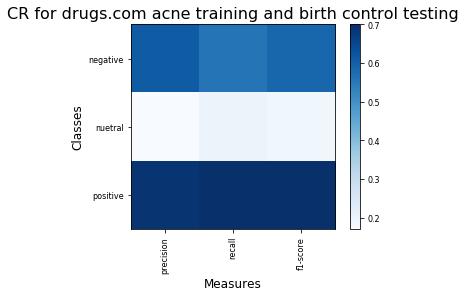

              precision    recall  f1-score   support

           1       0.64      0.52      0.57        27
           2       0.11      0.09      0.10        11
           3       0.46      0.57      0.51        30

   micro avg       0.47      0.47      0.47        68
   macro avg       0.40      0.39      0.39        68
weighted avg       0.47      0.47      0.47        68



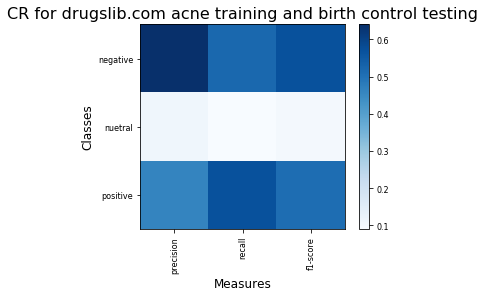

Modeling completed for training set acne and testing set birth control
Confusion matrix, without normalization


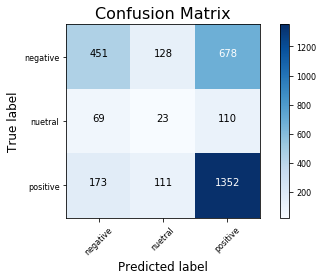

Confusion matrix, without normalization


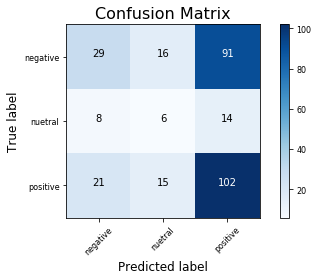

              precision    recall  f1-score   support

           1       0.65      0.36      0.46      1257
           2       0.09      0.11      0.10       202
           3       0.63      0.83      0.72      1636

   micro avg       0.59      0.59      0.59      3095
   macro avg       0.46      0.43      0.43      3095
weighted avg       0.60      0.59      0.57      3095



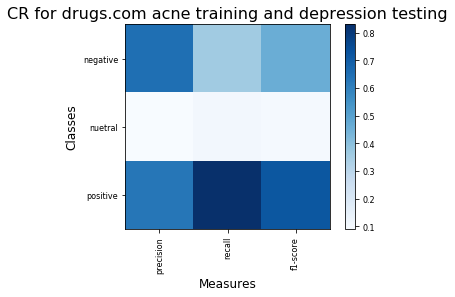

              precision    recall  f1-score   support

           1       0.50      0.21      0.30       136
           2       0.16      0.21      0.18        28
           3       0.49      0.74      0.59       138

   micro avg       0.45      0.45      0.45       302
   macro avg       0.38      0.39      0.36       302
weighted avg       0.47      0.45      0.42       302



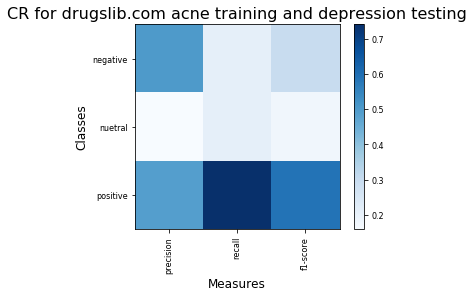

Modeling completed for training set acne and testing set depression


C:\Users\Kathleen Lange\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Kathleen Lange\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:373: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


Confusion matrix, without normalization


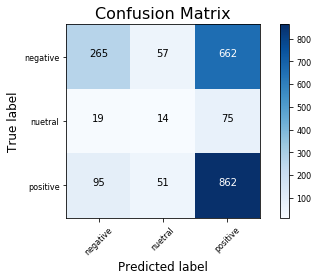

Confusion matrix, without normalization


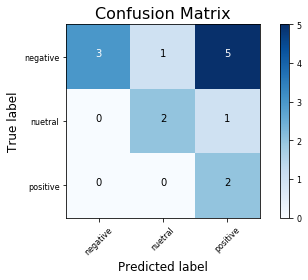

              precision    recall  f1-score   support

           1       0.70      0.27      0.39       984
           2       0.11      0.13      0.12       108
           3       0.54      0.86      0.66      1008

   micro avg       0.54      0.54      0.54      2100
   macro avg       0.45      0.42      0.39      2100
weighted avg       0.59      0.54      0.51      2100



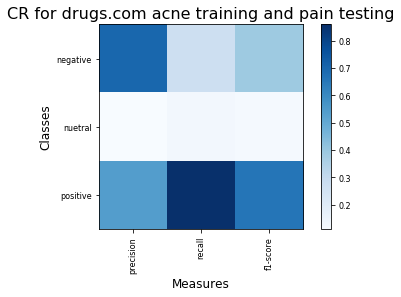

              precision    recall  f1-score   support

           1       1.00      0.33      0.50         9
           2       0.67      0.67      0.67         3
           3       0.25      1.00      0.40         2

   micro avg       0.50      0.50      0.50        14
   macro avg       0.64      0.67      0.52        14
weighted avg       0.82      0.50      0.52        14



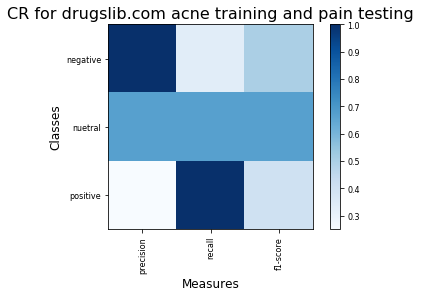

Modeling completed for training set acne and testing set pain
Confusion matrix, without normalization


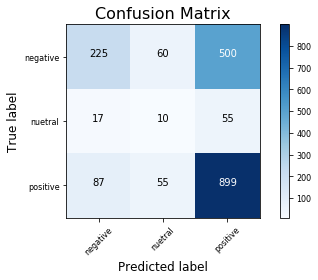

Confusion matrix, without normalization


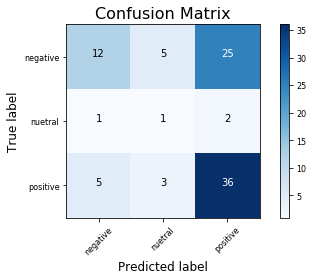

              precision    recall  f1-score   support

           1       0.68      0.29      0.40       785
           2       0.08      0.12      0.10        82
           3       0.62      0.86      0.72      1041

   micro avg       0.59      0.59      0.59      1908
   macro avg       0.46      0.42      0.41      1908
weighted avg       0.62      0.59      0.56      1908



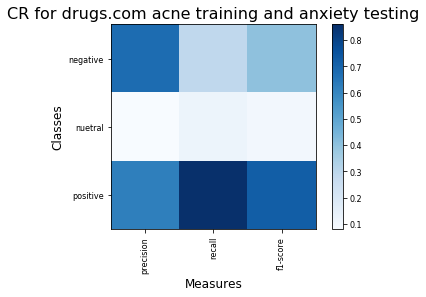

              precision    recall  f1-score   support

           1       0.67      0.29      0.40        42
           2       0.11      0.25      0.15         4
           3       0.57      0.82      0.67        44

   micro avg       0.54      0.54      0.54        90
   macro avg       0.45      0.45      0.41        90
weighted avg       0.60      0.54      0.52        90



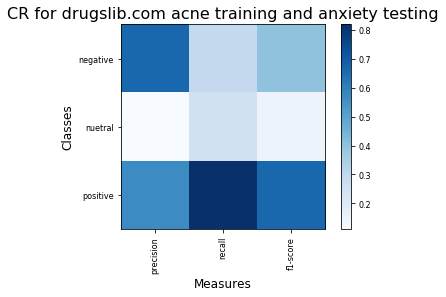

Modeling completed for training set acne and testing set anxiety
Confusion matrix, without normalization


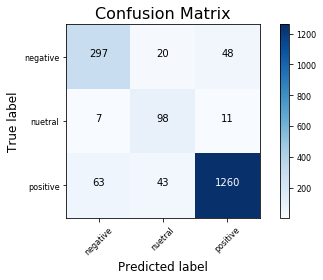

Confusion matrix, without normalization


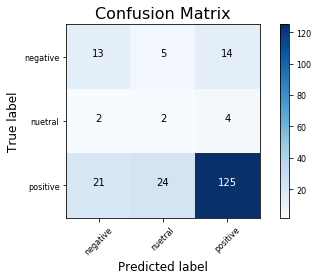

              precision    recall  f1-score   support

           1       0.81      0.81      0.81       365
           2       0.61      0.84      0.71       116
           3       0.96      0.92      0.94      1366

   micro avg       0.90      0.90      0.90      1847
   macro avg       0.79      0.86      0.82      1847
weighted avg       0.90      0.90      0.90      1847



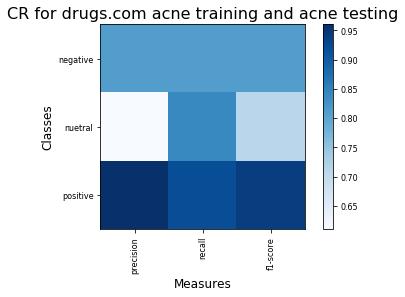

              precision    recall  f1-score   support

           1       0.36      0.41      0.38        32
           2       0.06      0.25      0.10         8
           3       0.87      0.74      0.80       170

   micro avg       0.67      0.67      0.67       210
   macro avg       0.43      0.46      0.43       210
weighted avg       0.77      0.67      0.71       210



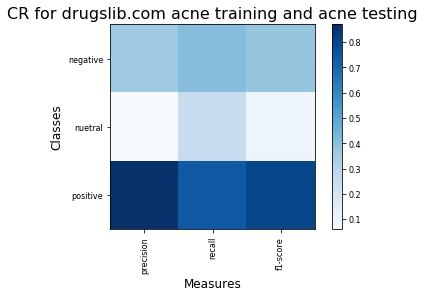

Modeling completed for training set acne and testing set acne
Wall time: 55.4 s


In [31]:
%%time
cond_lst = ['birth control', 'depression', 'pain', 'anxiety', 'acne'] # top 5 conditions reported drugs.com

scores_com = []
scores_lib = []
metrics_com = []
metrics_lib = []

for cond_iter1 in cond_lst:
    
    # get training data subset
    cond_sub_train = com_train.loc[com_train['condition'].str.lower()==cond_iter1]
    
    # create TFIDF bigrams vectorizer and fit to training subset
    vect = TfidfVectorizer(min_df=3, ngram_range=(1, 2))
    sub_train_feats = vect.fit_transform(cond_sub_train['review_clean'])
    
    # create training labels
    sub_train_labels = cond_sub_train['qual_rating']
    
    # build model
    sub_LSVC_TFIDF_model = LinearSVC(random_state=42, class_weight='balanced').fit(sub_train_feats, sub_train_labels)
    scoring = {'Cohen_Kappa': make_scorer(cohen_kappa_score), 'Accuracy': make_scorer(accuracy_score)}

    for cond_iter2 in cond_lst:
        # get testing data subsets
        cond_sub_test_com = com_test.loc[com_test['condition'].str.lower()==cond_iter2]
        cond_sub_test_lib = df_lib.loc[df_lib['condition'].str.lower()==cond_iter2]
        
        # create TFIDF bigram features for test sets
        test_feats_com = vect.transform(cond_sub_test_com['review_clean'])
        test_feats_lib = vect.transform(cond_sub_test_lib['all_reviews'])
   
        # create testing labels for metric calculations
        test_labels_com = cond_sub_test_com['qual_rating']
        test_labels_lib = cond_sub_test_lib['qual_rating']
    
        accuracies_com = cross_validate(sub_LSVC_TFIDF_model, 
                                    test_feats_com, test_labels_com, 
                                    scoring=scoring, cv=5)

        accuracies_lib = cross_validate(sub_LSVC_TFIDF_model, 
                            test_feats_lib, test_labels_lib, 
                            scoring=scoring, cv=5)
        metrics_com.append([cond_iter1, cond_iter2, 
                            np.nanmean(accuracies_com['test_Accuracy']), 
                            np.nanmean(accuracies_com['test_Cohen_Kappa'])])
        metrics_lib.append([cond_iter1, cond_iter2, 
                            np.nanmean(accuracies_lib['test_Accuracy']),
                            np.nanmean(accuracies_lib['test_Cohen_Kappa'])])
    
        # make predictions with trained model
        predictions_com = sub_LSVC_TFIDF_model.predict(test_feats_com) 
        predictions_lib = sub_LSVC_TFIDF_model.predict(test_feats_lib)
        
        # return acc and ck scores 
        scores_com.append([cond_iter1, cond_iter2, 
                           accuracy_score(predictions_com, test_labels_com), 
                           cohen_kappa_score(predictions_com, test_labels_com)])
        scores_lib.append([cond_iter1, cond_iter2, 
                           accuracy_score(predictions_lib, test_labels_lib), 
                           cohen_kappa_score(predictions_lib, test_labels_lib)])
        
        # show confusion matrices and classification reports
        cm_com = confusion_matrix(predictions_com, test_labels_com)
        plot_confusion_matrix(cm_com, normalize=False)
        cm_lib = confusion_matrix(predictions_lib, test_labels_lib)
        plot_confusion_matrix(cm_lib, normalize=False)

        cr_com = classification_report(predictions_com, test_labels_com)
        print(cr_com)
        plot_classification_report(cr_com, 'CR for drugs.com {0} training and {1} testing'.format(cond_iter1, cond_iter2))
        cr_lib = classification_report(predictions_lib, test_labels_lib)
        print(cr_lib)
        plot_classification_report(cr_lib, 'CR for drugslib.com {0} training and {1} testing'.format(cond_iter1, cond_iter2))

        print('Modeling completed for training set {0} and testing set {1}'.format(cond_iter1, cond_iter2))
        
com_cv_df = pd.DataFrame(metrics_com, columns=['training condition', 'testing condition', 'mean accuracy', 'mean cohen-kappa'])
lib_cv_df = pd.DataFrame(metrics_lib, columns=['training condition', 'testing condition', 'mean accuracy', 'mean cohen-kappa'])

From the above confusion matrices and classification reports, the results seem similar to the overall dataset model. The positive class is the easiest to classify while the neutral class is significantly harder to classify. 

I performed the above testing using a cross validation technique on the training set and using the same source (Drugs.com) testing set. There seems to be some overfitting in my model because the results of the cross validation technique (the mean accuracy and Cohen Kappa score) are slightly lower than the metrics returned from the testing set.

In [32]:
df_scores_com = pd.DataFrame(scores_com, columns=['training', 'testing', 'acc', 'ck'])
df_scores_com['source'] = 'drugs.com'
df_scores_lib = pd.DataFrame(scores_lib, columns=['training', 'testing', 'acc', 'ck'])
df_scores_lib['source'] = 'drugslib.com'
df_scores = pd.concat([df_scores_com, df_scores_lib])

The below plot shows the accuracy of the each subset condition model on different training/testing sets. The plot on the left has testing sets coming from the Drugs.com source while the plot on the right shows testing sets coming from the Drugslib.com source. Both plots are trained on data from Drugs.com. 

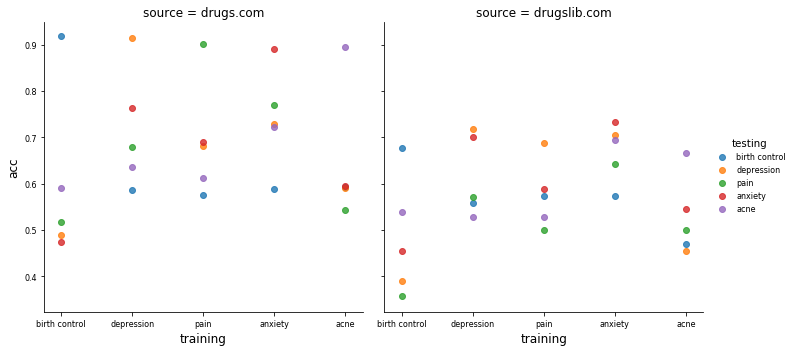

In [33]:
sns.lmplot('training', 'acc', data=df_scores, hue='testing', fit_reg=False, col='source')
plt.show()

This next plot is the same as the above one, however it is showing the Cohen Kappa score instead of accuracy.

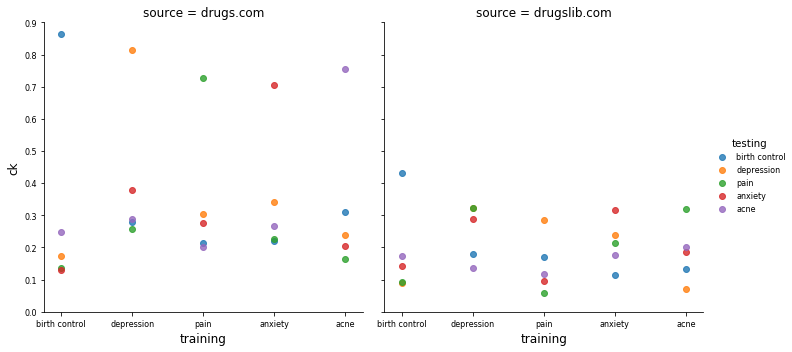

In [34]:
g = sns.lmplot('training', 'ck', data=df_scores, hue='testing', fit_reg=False, col='source', sharex=False, sharey=True)
g.set(ylim=(0, 0.9))
plt.show()

# Compare to Article Results

## Overall Results

From the article, I uploaded their best results and plot them with respect to the result I found above.

In [35]:
dfcompall = pd.DataFrame({'TrainingSet':['Drugs.com Train', 'Drugs.com Train', 'Drugs.com Train', 'Drugs.com Train', 'Drugs.com Train', 'Drugs.com Train', 'Drugs.com Train', 'Drugs.com Train', 'Drugslib.com Train', 'Drugslib.com Train', 'Drugslib.com Train', 'Drugslib.com Train', 'Drugslib.com Train', 'Drugslib.com Train', 'Drugslib.com Train', 'Drugslib.com Train'],
                          'TestingSet':['Drugs.com Test', 'Drugslib.com Test', 'Drugs.com Test', 'Drugslib.com Test', 'Drugs.com Test', 'Drugslib.com Test', 'Drugs.com Test', 'Drugslib.com Test', 'Drugs.com Test', 'Drugslib.com Test', 'Drugs.com Test', 'Drugslib.com Test', 'Drugs.com Test', 'Drugslib.com Test', 'Drugs.com Test', 'Drugslib.com Test'], 
                          'Metric':['Accuracy', 'Accuracy', 'Accuracy', 'Accuracy', 'CohenKappa', 'CohenKappa', 'CohenKappa', 'CohenKappa', 'Accuracy', 'Accuracy', 'Accuracy', 'Accuracy', 'CohenKappa', 'CohenKappa', 'CohenKappa', 'CohenKappa'], 
                          'Score':[89.2, 70.9, 92.2, 75.3, 77.9, 33.7, 84.0, 48.1, 64.9, 70.6, 70.06, 75.19, 26.7, 36.4, 26.76, 43.59], 
                          'Analyzer':['LinearSVC', 'Gräßer et. al.', 'Gräßer et. al.', 'Gräßer et. al.', 'LinearSVC', 'LinearSVC', 'Gräßer et. al.', 'Gräßer et. al.', 'LinearSVC', 'LinearSVC', 'Gräßer et. al.', 'Gräßer et. al.', 'LinearSVC', 'LinearSVC', 'Gräßer et. al.', 'Gräßer et. al.']})

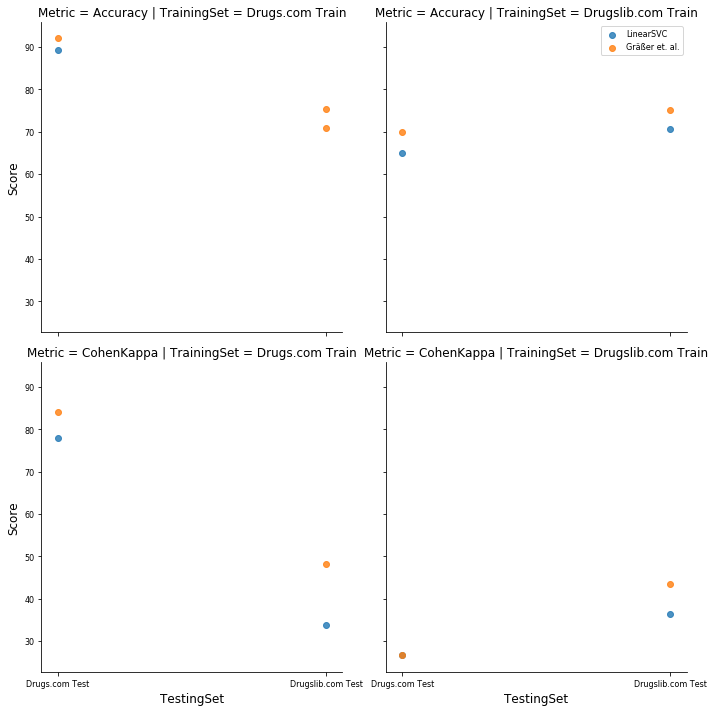

In [36]:
g = sns.lmplot('TestingSet', 'Score', hue='Analyzer', col='TrainingSet', row='Metric', 
           data=dfcompall, fit_reg=False, legend=False)
g.fig.get_axes()[1].legend(loc='upper right')
plt.show()

The article's results are shown in orange above. The top two plots show the accuracy metric whereas the bottom two plots indicate the Cohen Kappa metric. The two plots on the left show the Drugs.com training set while the two plots on the right show the Drugslib.com training set. The x-axis is the testing set used to create the predictions.

Overall, the article's classifiers performed better than mine did, mostly about 5% better. However, the trends for both my analysis and the article's were similar. Using the Drugs.com training and testing sets gave the best scores overall while on the other hand, using the Drugslib.com training set and the Drugs.com testing sets gave the worst overall scores.

## Condition Specific Results

Each separate plot below shows a a different training data subset condition. The results I got are in blue while the results from the article are in orange. The top four plots are for the accuracy scores and the bottom four plots are for the Cohen Kappa scores.

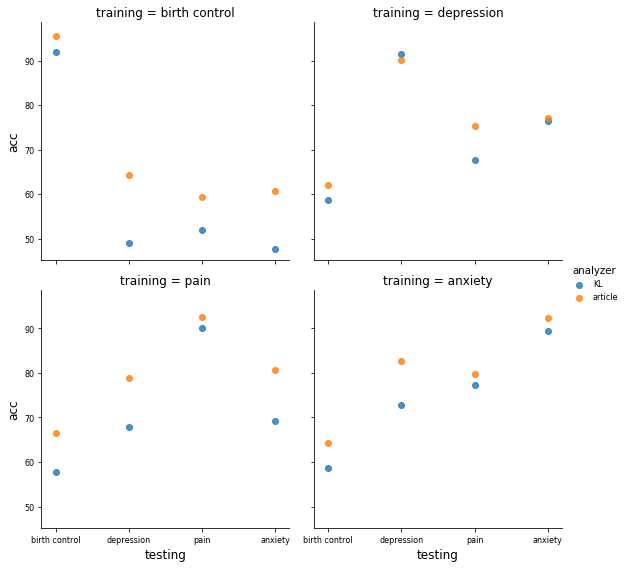

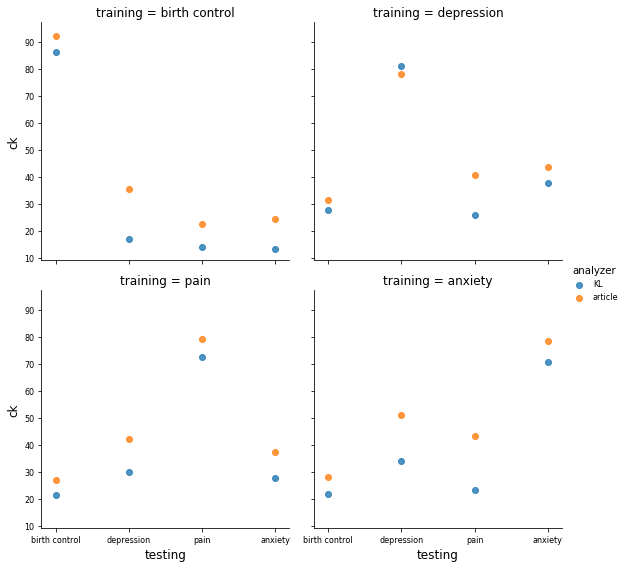

In [37]:
dfcomp = pd.read_csv('cond_accs_ck.csv')
sns.lmplot('testing', 'acc', hue='analyzer', col='training', data=dfcomp, fit_reg=False, col_wrap=2, height=4)
sns.lmplot('testing', 'ck', hue='analyzer', col='training', data=dfcomp, fit_reg=False, col_wrap=2, height=4)
plt.show()

Similar to the overall results, the subset results show that the article's classifier perfrmed slightly better than mine for all of the subsets. However, the trends between the different conditions remained the same.

# Future Improvements

From the above analysis, I showed that the work performed by the article author's could be repeatable using a different method of building features and using a different classifier model. The trends I saw in my accuracies and Cohen Kappa scores closely followed the article's results, however, their results consistently scored slightly better than mine. 

To improve on my own analysis there are a number of things I could take into account such as some of the following:
- Use word2vec or spaCy vectors as features instead of TFIDF. These vectors take into account similar/relative words. For example, 'beige', 'tan', and 'white' might all have similiar vectors that could help improve the classifier performance.
- Leave in stopwords from the text cleaning and just rely on the max_df parameter of the vectorizer, or the maximum number of times a word/bigram can appear in the text, to eliminate features that are not as useful. This was the method followed by the article authors and may keep in important bi-/tri-grams.
- Combine conditions with very similiar, if not the exact same, meanings for the condition subsets so that larger training sets can be created. For example, create a list of all the contraceptive type of conditions including 'birth control', 'contraceptive', 'birth prevention', 'family planning', 'emergency contraception', etc.